In [162]:
%reload_ext autoreload
%autoreload 1

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sys
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, Ridge, Lasso, ElasticNet
sys.path.append('../src')

from features.eda import eda_column_subset
from models.model_validation import cross_val, print_coef, find_consistent_train_test_split, validate_train_test_split, generate_LARS_plot, run_stats_models, generate_resid_plots
from data.clean_high_districts import clean_data
%aimport features.eda
%aimport models.model_validation
%aimport data.clean_high_districts

# Load Data

In [3]:
raw = pd.read_csv('../data/interim/high_school_districts_almost_ready.csv')

# EDA

In [4]:
raw = raw.drop(columns=['Unnamed: 0'])

In [5]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 473 entries, 0 to 472
Data columns (total 21 columns):
avg_sat_both                           473 non-null float64
#_student_enrollment                   473 non-null float64
%_student_enrollment__homeless         473 non-null float64
%_student_enrollment__low_income       473 non-null float64
%_student_enrollment__iep              473 non-null float64
%_student_enrollment__el               473 non-null float64
student_attendance_rate                473 non-null float64
student_mobility_rate                  473 non-null float64
student_chronic_truancy_rate           473 non-null float64
avg_teaching_exp                       472 non-null float64
bachelor_degree                        472 non-null float64
pupil_teacher_ratio__high_school       472 non-null float64
teacher_retention_rate                 472 non-null float64
teacher_attendace_rate                 468 non-null float64
inst_and_support                       468 non-null flo

In [6]:
ind_var = 'avg_sat_both'
expl_var = [x for x in raw.columns if x != ind_var]

bucket_size = int(np.ceil(len(expl_var) / 4))

first = expl_var[:bucket_size]
second = expl_var[bucket_size:(2*bucket_size)]
third = expl_var[(2*bucket_size):(3*bucket_size)]
fourth = expl_var[(3* bucket_size):]

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/lib/histograms.py:839: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/lib/histograms.py:840: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


avg_sat_both  #_student_enrollment  %_student_enrollment__homeless  \
count    473.000000            473.000000                      473.000000   
mean       2.072638           2308.414376                        1.854123   
std        0.324883           3911.820581                        2.970139   
min        1.125000            124.000000                        0.000000   
10%        1.683900            355.200000                        0.000000   
25%        1.872500            529.000000                        0.000000   
50%        2.047500            992.000000                        0.800000   
75%        2.269000           2221.000000                        2.400000   
90%        2.473600           5585.800000                        5.300000   
max        3.204500          38764.000000                       31.400000   

       %_student_enrollment__low_income  %_student_enrollment__iep  \
count                        473.000000                 473.000000   
mean                          42.715645                  15.317336   
std                           18.457999                   3.368913   
min                            2.100000                   0.000000   
10%                           18.000000                  11.500000   
25%                           30.000000                  12.800000   
50%                           42.600000                  15.000000   
75%                           54.100000                  17.500000   
90%                           64.380000                  20.000000   
max                           99.600000                  25.900000   

       %_student_enrollment__el  student_attendance_rate  \
count                473.000000               473.000000   
mean                   2.496617                94.073150   
std                    5.642509                 1.936223   
min                    0.000000                78.700000   
10%                    0.000000                92.300000   
25%                    0.000000                93.600000   
50%                    0.000000                94.500000   
75%                    2.300000                95.100000   
90%                    7.680000                95.700000   
max                   39.000000                98.200000   

       student_mobility_rate  student_chronic_truancy_rate  avg_teaching_exp  \
count             473.000000                    473.000000        472.000000   
mean                8.149260                      5.994503         13.890890   
std                 3.886445                      8.286379          2.053411   
min                 1.000000                      0.000000          3.200000   
10%                 3.900000                      0.800000         11.410000   
25%                 5.500000                      1.600000         12.800000   
50%                 7.800000                      3.500000         13.900000   
75%                10.200000                      7.400000         15.100000   
90%                12.480000                     13.080000         16.400000   
max                35.700000                     85.800000         20.400000   

       bachelor_degree  
count       472.000000  
mean         50.480720  
std          18.002051  
min           5.200000  
10%          24.720000  
25%          37.775000  
50%          51.500000  
75%          63.325000  
90%          73.090000  
max          88.900000

<Figure size 2880x2880 with 0 Axes>

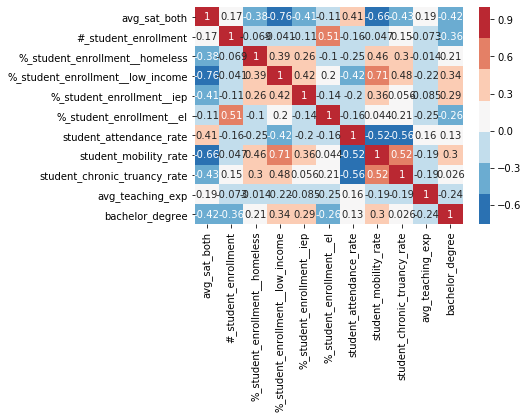

In [7]:
eda_column_subset(raw, [ind_var] + first + second)

In [8]:
# there's a school with high low-income and 0% iep (might be a mis-handled null)
# one district is major outlier in both homeless and low-income
# mobility and low_income biggest correl to worry about (.71)

# avg_teach_exp, bachelor is pretty normal => take median to fill null


avg_sat_both  #_student_enrollment  %_student_enrollment__homeless  \
count    473.000000            473.000000                      473.000000   
mean       2.072638           2308.414376                        1.854123   
std        0.324883           3911.820581                        2.970139   
min        1.125000            124.000000                        0.000000   
10%        1.683900            355.200000                        0.000000   
25%        1.872500            529.000000                        0.000000   
50%        2.047500            992.000000                        0.800000   
75%        2.269000           2221.000000                        2.400000   
90%        2.473600           5585.800000                        5.300000   
max        3.204500          38764.000000                       31.400000   

       %_student_enrollment__low_income  %_student_enrollment__iep  \
count                        473.000000                 473.000000   
mean                          42.715645                  15.317336   
std                           18.457999                   3.368913   
min                            2.100000                   0.000000   
10%                           18.000000                  11.500000   
25%                           30.000000                  12.800000   
50%                           42.600000                  15.000000   
75%                           54.100000                  17.500000   
90%                           64.380000                  20.000000   
max                           99.600000                  25.900000   

       %_student_enrollment__el  pupil_teacher_ratio__high_school  \
count                473.000000                        472.000000   
mean                   2.496617                         15.781568   
std                    5.642509                          4.479581   
min                    0.000000                          5.100000   
10%                    0.000000                          9.600000   
25%                    0.000000                         12.600000   
50%                    0.000000                         16.250000   
75%                    2.300000                         18.925000   
90%                    7.680000                         20.980000   
max                   39.000000                         33.900000   

       teacher_retention_rate  teacher_attendace_rate  inst_and_support  \
count              472.000000              468.000000        468.000000   
mean                86.705720               72.632051         75.273504   
std                  6.573358               12.425387         10.221597   
min                 56.000000                1.800000         20.900000   
10%                 78.220000               57.140000         63.010000   
25%                 83.500000               66.175000         70.300000   
50%                 88.100000               73.700000         77.200000   
75%                 91.500000               80.725000         82.200000   
90%                 93.400000               87.130000         85.800000   
max                 99.000000              100.000000         92.100000   

       %_ebf_capacity_to_meet_expectations  
count                           468.000000  
mean                             74.243376  
std                              22.175654  
min                              47.000000  
10%                              56.870000  
25%                              60.800000  
50%                              67.800000  
75%                              78.800000  
90%                             100.980000  
max                             198.000000

<Figure size 2880x2880 with 0 Axes>

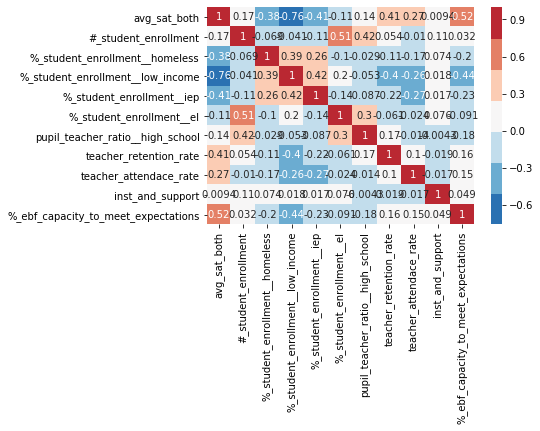

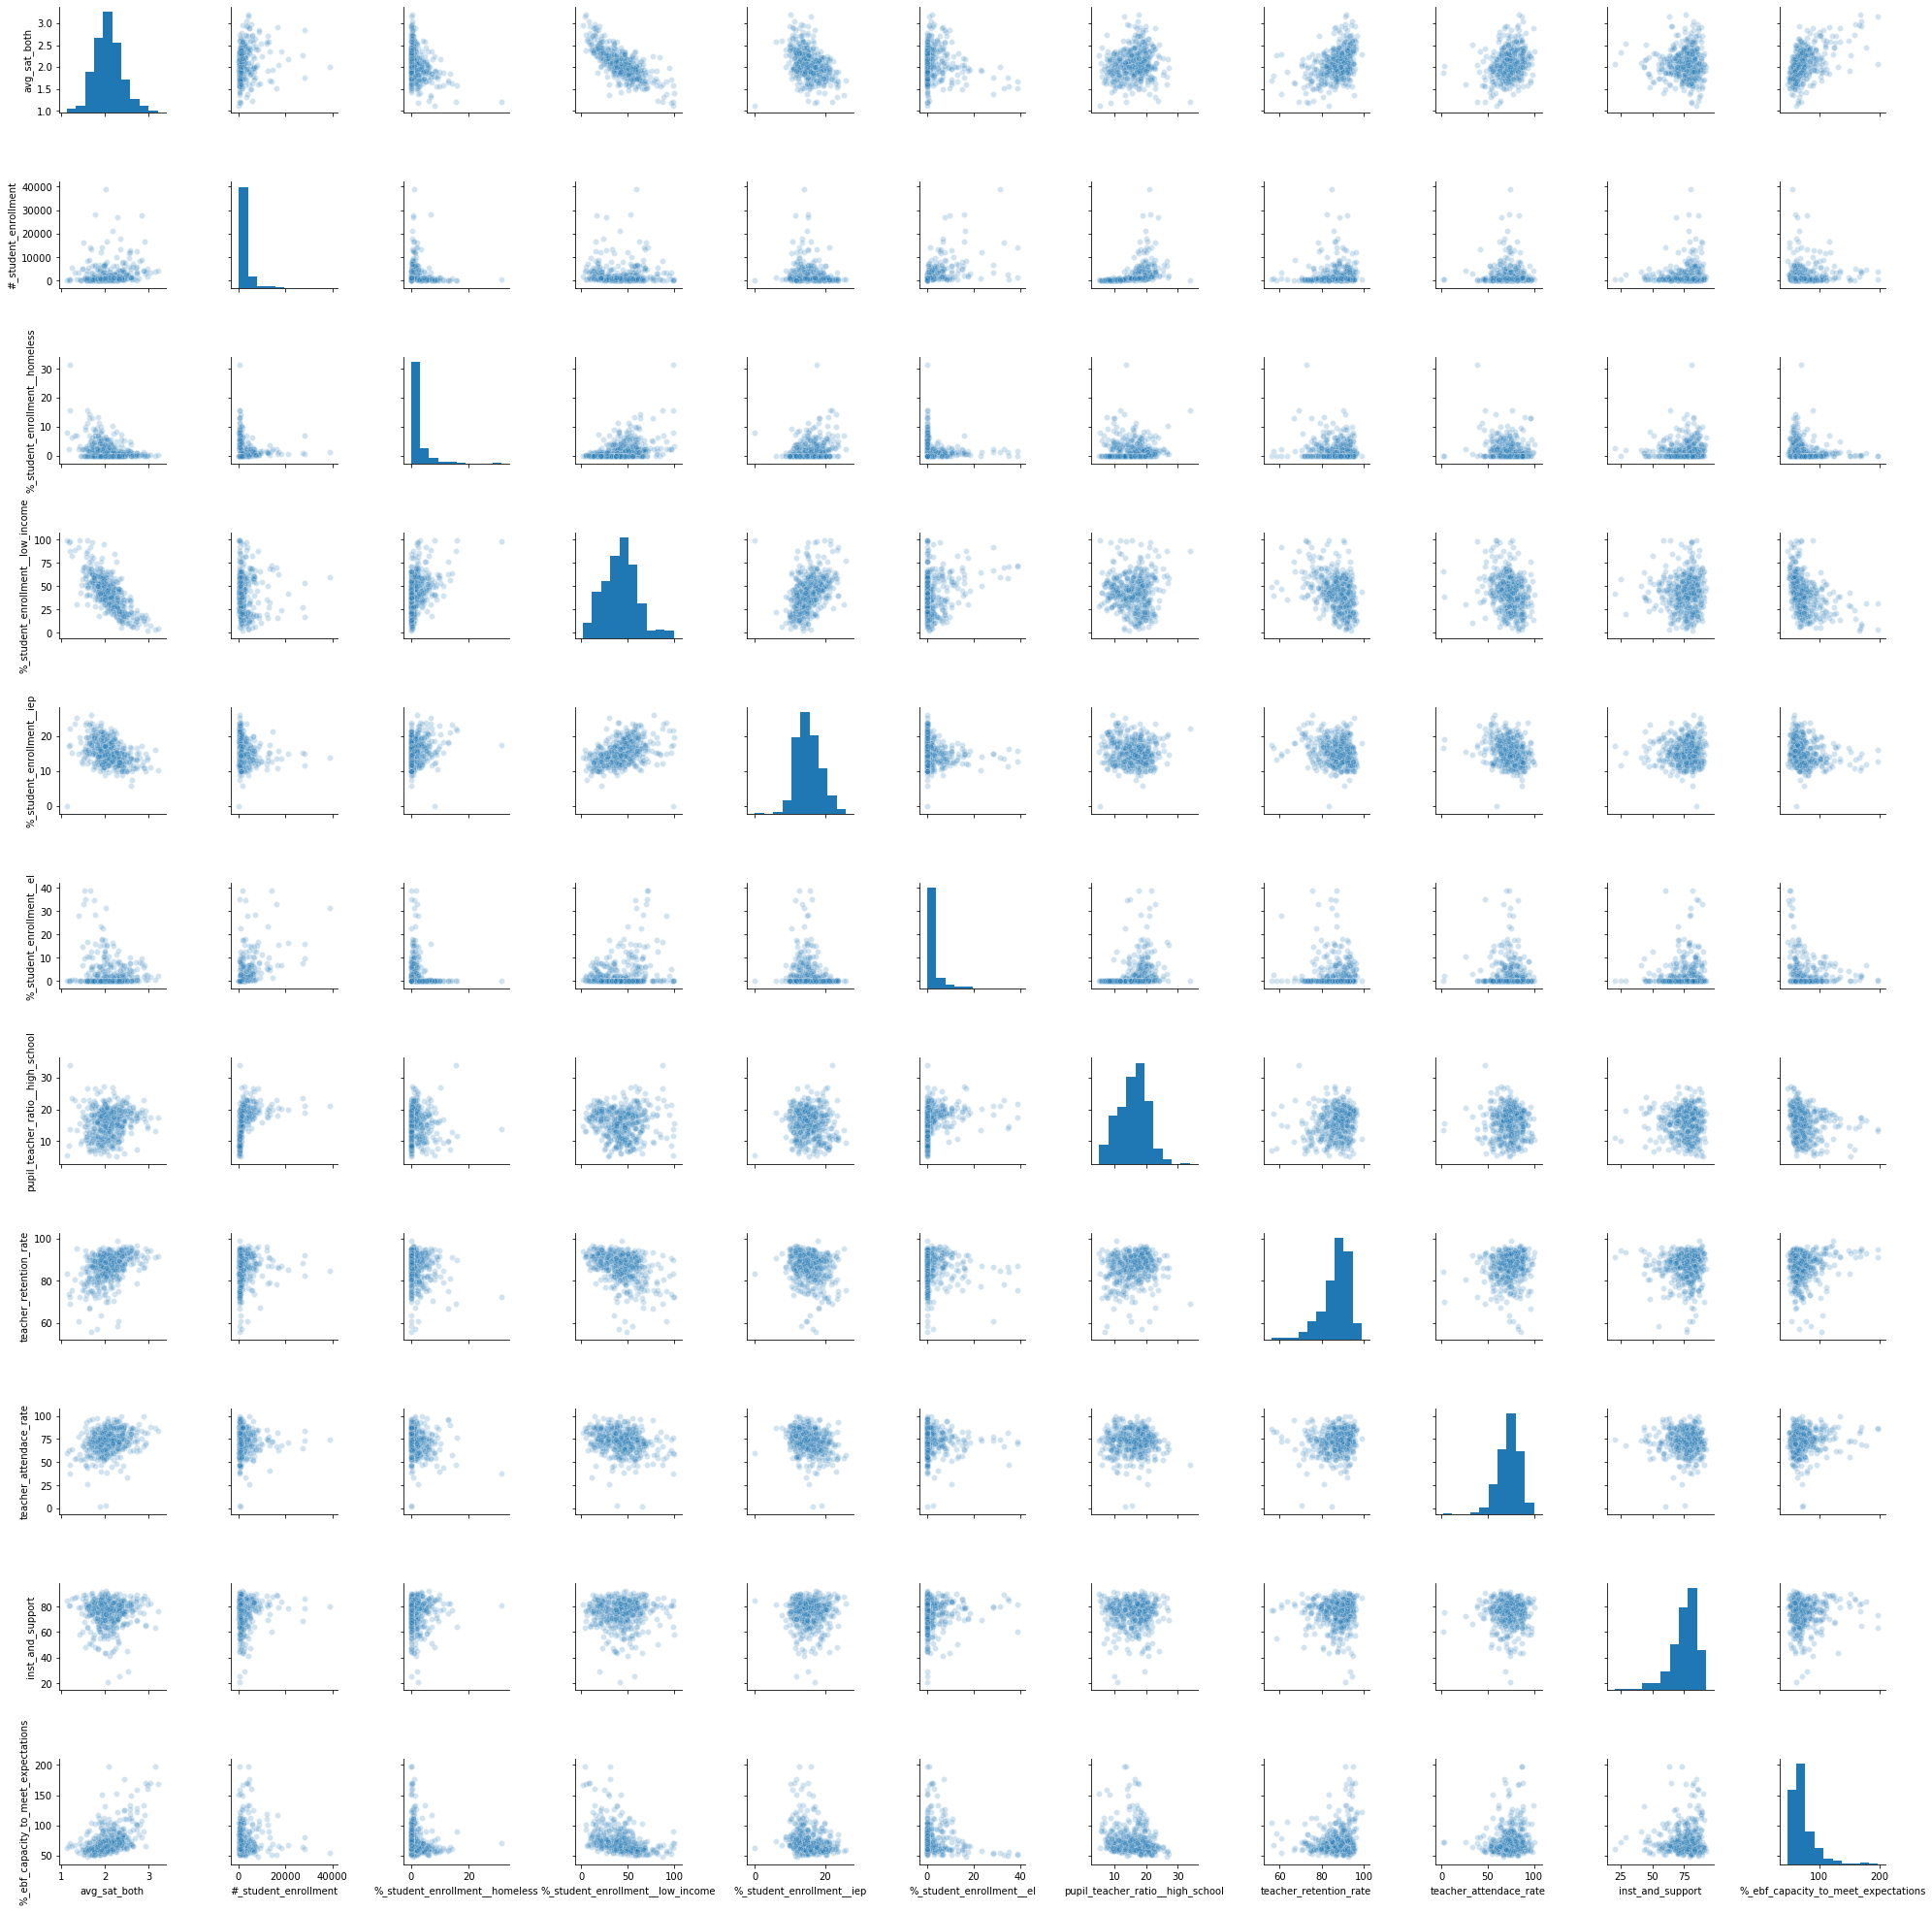

In [9]:
eda_column_subset(raw, [ind_var] + first + third)

In [10]:
# % ebf is pretty right skewed and somewhat correl with low-income
    # also, pretty strongly correl with ind var
    # makes me hesitant to impute with mean, median (perhaps drop or k-nearest neighbors)
# inst_and_support is pretty low correl so might drop that column anyway
# lots of things a little correlated with low_income
# might have heteroskedasticity btwn %ebf and sat

avg_sat_both  #_student_enrollment  %_student_enrollment__homeless  \
count    473.000000            473.000000                      473.000000   
mean       2.072638           2308.414376                        1.854123   
std        0.324883           3911.820581                        2.970139   
min        1.125000            124.000000                        0.000000   
10%        1.683900            355.200000                        0.000000   
25%        1.872500            529.000000                        0.000000   
50%        2.047500            992.000000                        0.800000   
75%        2.269000           2221.000000                        2.400000   
90%        2.473600           5585.800000                        5.300000   
max        3.204500          38764.000000                       31.400000   

       %_student_enrollment__low_income  %_student_enrollment__iep  \
count                        473.000000                 473.000000   
mean                          42.715645                  15.317336   
std                           18.457999                   3.368913   
min                            2.100000                   0.000000   
10%                           18.000000                  11.500000   
25%                           30.000000                  12.800000   
50%                           42.600000                  15.000000   
75%                           54.100000                  17.500000   
90%                           64.380000                  20.000000   
max                           99.600000                  25.900000   

       %_student_enrollment__el  avg_class_size__high_school  \
count                473.000000                   473.000000   
mean                   2.496617                    16.640592   
std                    5.642509                     4.341098   
min                    0.000000                     5.000000   
10%                    0.000000                    11.000000   
25%                    0.000000                    14.000000   
50%                    0.000000                    17.000000   
75%                    2.300000                    20.000000   
90%                    7.680000                    22.000000   
max                   39.000000                    28.000000   

       admin_avg_salary  principal_turnover_within_6_years  pupil_admin_ratio  
count        472.000000                         472.000000         472.000000  
mean       97757.144386                           1.644068         172.987076  
std        18801.927792                           0.628758          53.834771  
min        47470.670000                           0.000000          62.500000  
10%        78295.262000                           1.000000         110.020000  
25%        86191.665000                           1.000000         134.675000  
50%        95901.665000                           2.000000         172.350000  
75%       105911.262500                           2.000000         204.100000  
90%       118230.650000                           2.000000         234.390000  
max       260021.320000                           4.000000         597.000000

<Figure size 2880x2880 with 0 Axes>

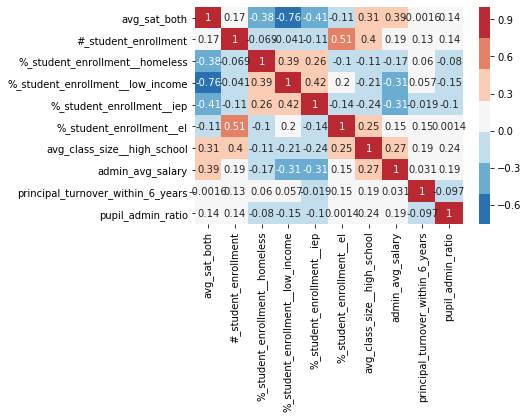

In [11]:
eda_column_subset(raw, [ind_var] + first + fourth)

In [12]:
# drop principle turnover (or perhaps polynomial it)
    # right now, low variance in metric has no rel with ind var
# major pupil-admin / avg-admin-sal outlier
# no correlations to really worry about

avg_sat_both  student_attendance_rate  student_mobility_rate  \
count    473.000000               473.000000             473.000000   
mean       2.072638                94.073150               8.149260   
std        0.324883                 1.936223               3.886445   
min        1.125000                78.700000               1.000000   
10%        1.683900                92.300000               3.900000   
25%        1.872500                93.600000               5.500000   
50%        2.047500                94.500000               7.800000   
75%        2.269000                95.100000              10.200000   
90%        2.473600                95.700000              12.480000   
max        3.204500                98.200000              35.700000   

       student_chronic_truancy_rate  avg_teaching_exp  bachelor_degree  \
count                    473.000000        472.000000       472.000000   
mean                       5.994503         13.890890        50.480720   
std                        8.286379          2.053411        18.002051   
min                        0.000000          3.200000         5.200000   
10%                        0.800000         11.410000        24.720000   
25%                        1.600000         12.800000        37.775000   
50%                        3.500000         13.900000        51.500000   
75%                        7.400000         15.100000        63.325000   
90%                       13.080000         16.400000        73.090000   
max                       85.800000         20.400000        88.900000   

       pupil_teacher_ratio__high_school  teacher_retention_rate  \
count                        472.000000              472.000000   
mean                          15.781568               86.705720   
std                            4.479581                6.573358   
min                            5.100000               56.000000   
10%                            9.600000               78.220000   
25%                           12.600000               83.500000   
50%                           16.250000               88.100000   
75%                           18.925000               91.500000   
90%                           20.980000               93.400000   
max                           33.900000               99.000000   

       teacher_attendace_rate  inst_and_support  \
count              468.000000        468.000000   
mean                72.632051         75.273504   
std                 12.425387         10.221597   
min                  1.800000         20.900000   
10%                 57.140000         63.010000   
25%                 66.175000         70.300000   
50%                 73.700000         77.200000   
75%                 80.725000         82.200000   
90%                 87.130000         85.800000   
max                100.000000         92.100000   

       %_ebf_capacity_to_meet_expectations  
count                           468.000000  
mean                             74.243376  
std                              22.175654  
min                              47.000000  
10%                              56.870000  
25%                              60.800000  
50%                              67.800000  
75%                              78.800000  
90%                             100.980000  
max                             198.000000

<Figure size 2880x2880 with 0 Axes>

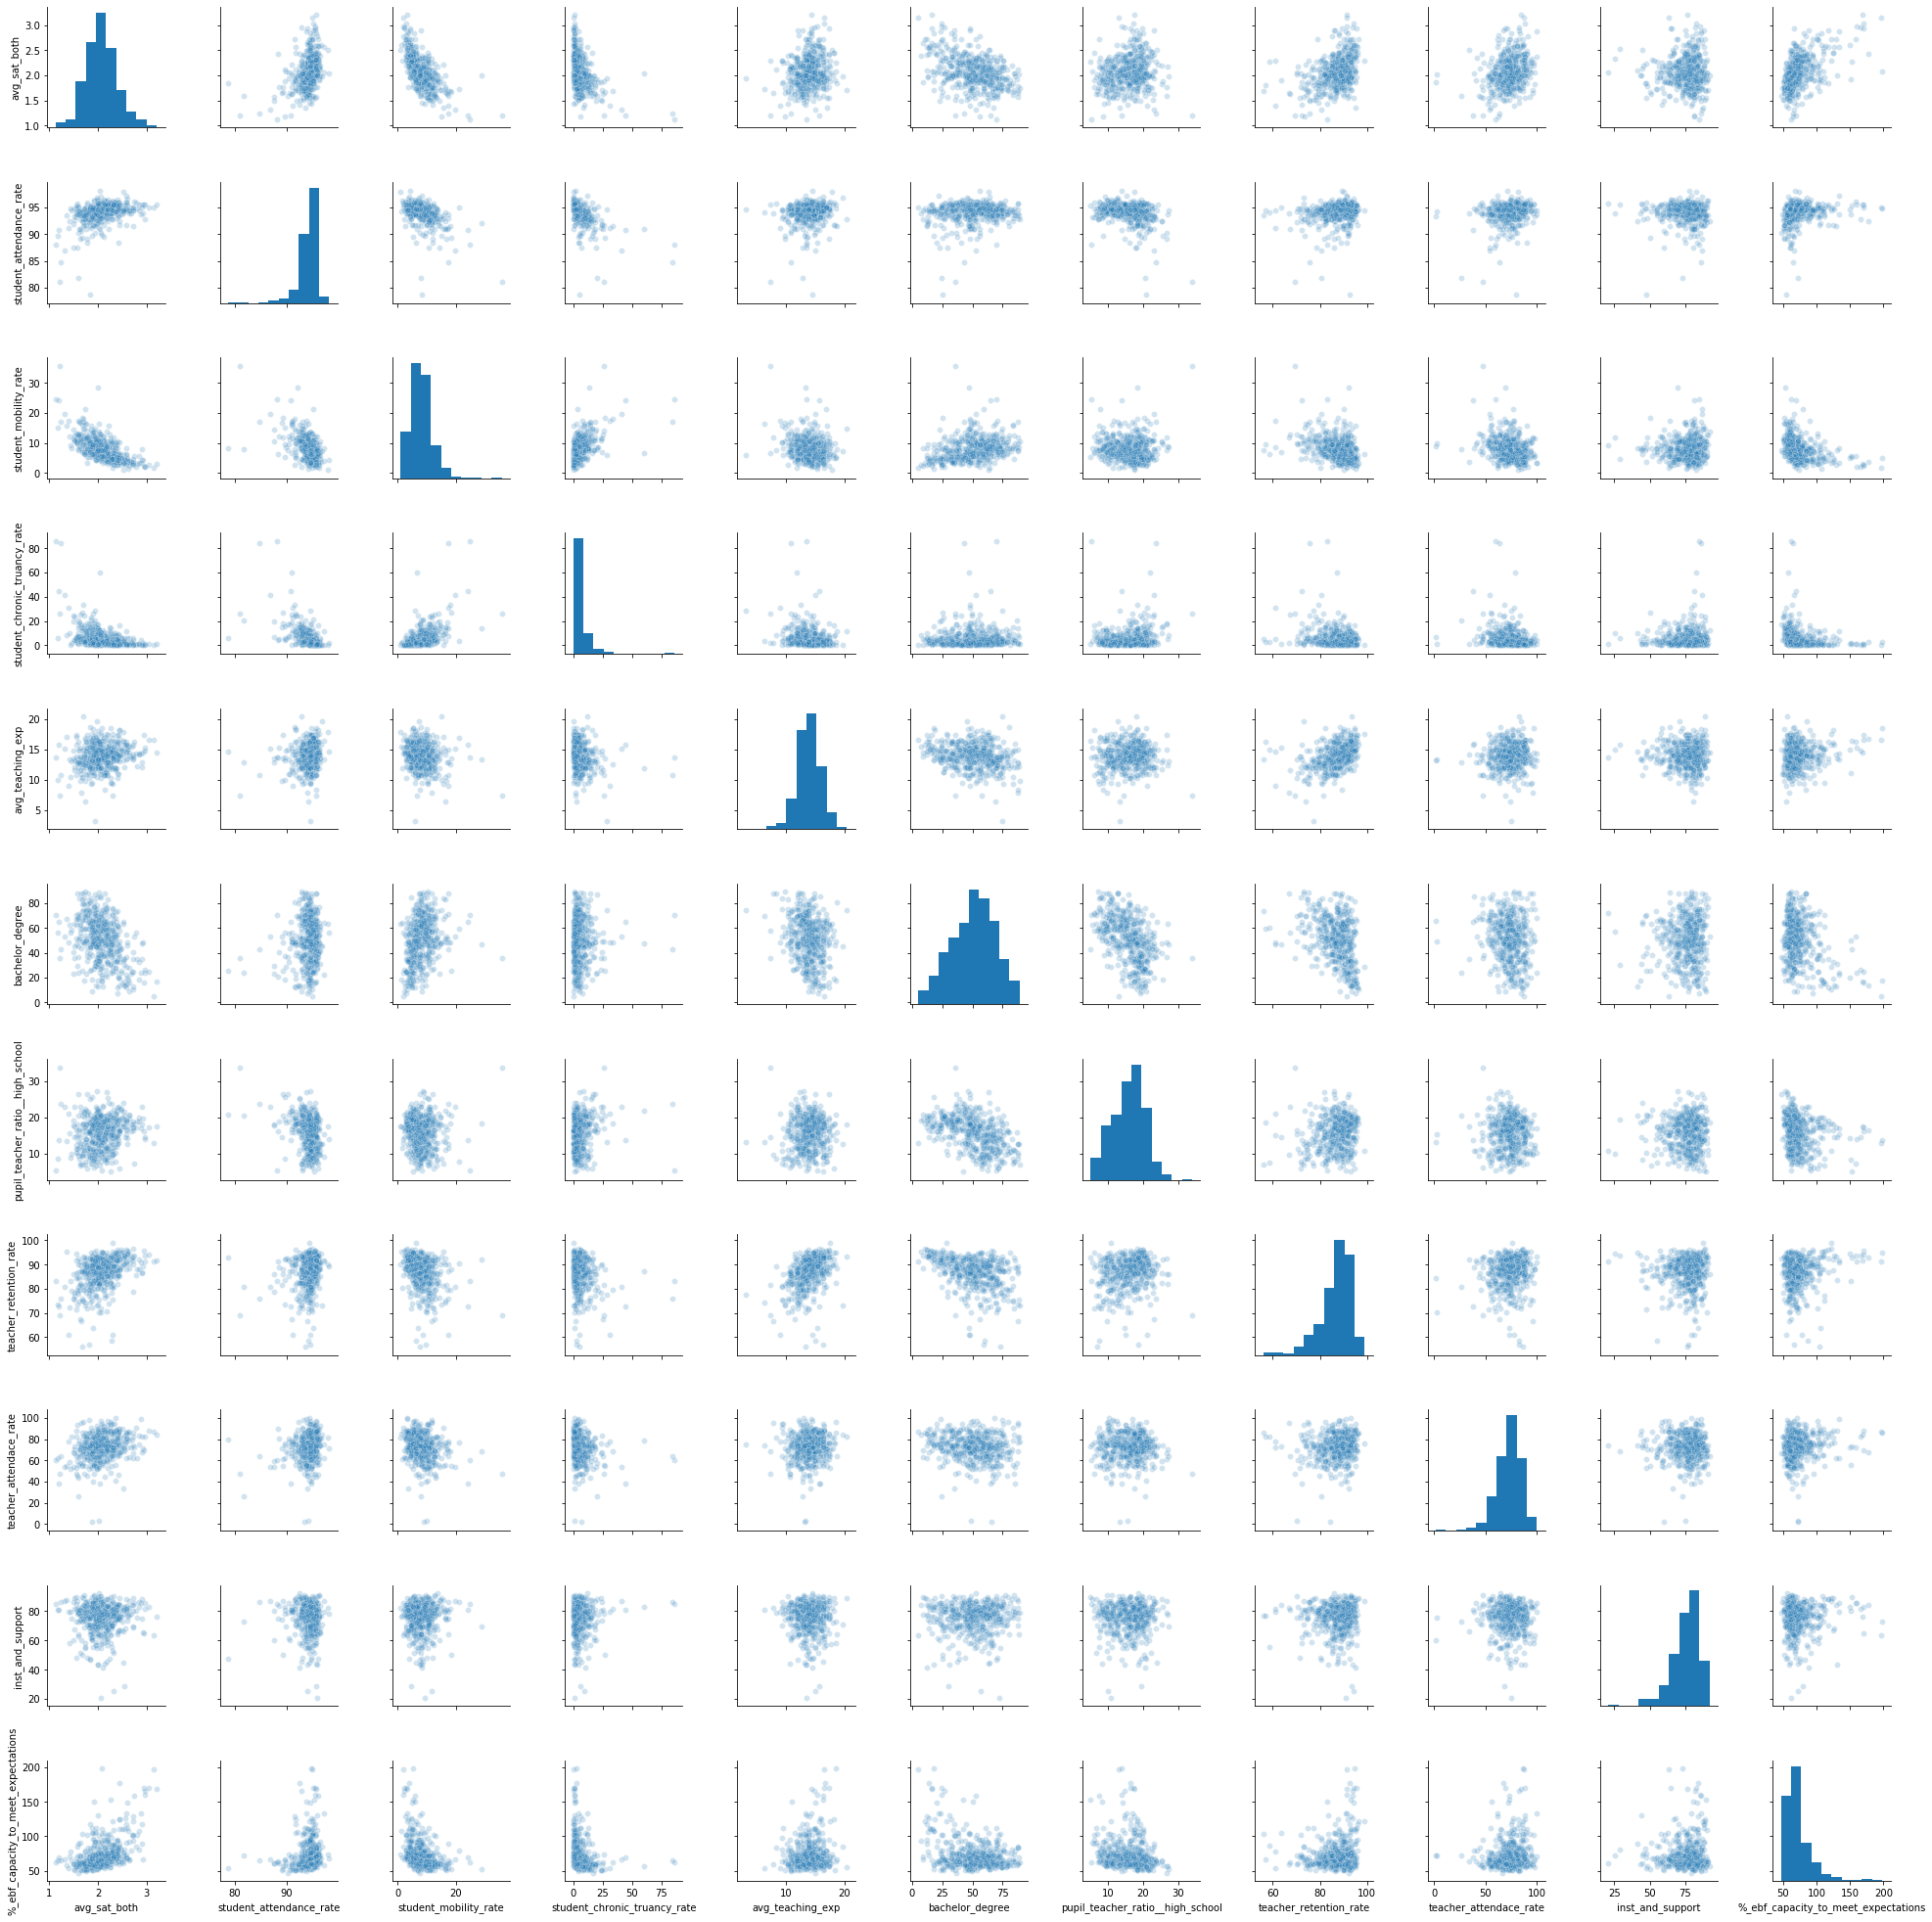

In [13]:
eda_column_subset(raw, [ind_var] + second + third)

In [14]:
# two teacher attendence values below 20% (almost 0) -> gotta be wrong
# might be a curve btwn sat and mobility

avg_sat_both  student_attendance_rate  student_mobility_rate  \
count    473.000000               473.000000             473.000000   
mean       2.072638                94.073150               8.149260   
std        0.324883                 1.936223               3.886445   
min        1.125000                78.700000               1.000000   
10%        1.683900                92.300000               3.900000   
25%        1.872500                93.600000               5.500000   
50%        2.047500                94.500000               7.800000   
75%        2.269000                95.100000              10.200000   
90%        2.473600                95.700000              12.480000   
max        3.204500                98.200000              35.700000   

       student_chronic_truancy_rate  avg_teaching_exp  bachelor_degree  \
count                    473.000000        472.000000       472.000000   
mean                       5.994503         13.890890        50.480720   
std                        8.286379          2.053411        18.002051   
min                        0.000000          3.200000         5.200000   
10%                        0.800000         11.410000        24.720000   
25%                        1.600000         12.800000        37.775000   
50%                        3.500000         13.900000        51.500000   
75%                        7.400000         15.100000        63.325000   
90%                       13.080000         16.400000        73.090000   
max                       85.800000         20.400000        88.900000   

       avg_class_size__high_school  admin_avg_salary  \
count                   473.000000        472.000000   
mean                     16.640592      97757.144386   
std                       4.341098      18801.927792   
min                       5.000000      47470.670000   
10%                      11.000000      78295.262000   
25%                      14.000000      86191.665000   
50%                      17.000000      95901.665000   
75%                      20.000000     105911.262500   
90%                      22.000000     118230.650000   
max                      28.000000     260021.320000   

       principal_turnover_within_6_years  pupil_admin_ratio  
count                         472.000000         472.000000  
mean                            1.644068         172.987076  
std                             0.628758          53.834771  
min                             0.000000          62.500000  
10%                             1.000000         110.020000  
25%                             1.000000         134.675000  
50%                             2.000000         172.350000  
75%                             2.000000         204.100000  
90%                             2.000000         234.390000  
max                             4.000000         597.000000

<Figure size 2880x2880 with 0 Axes>

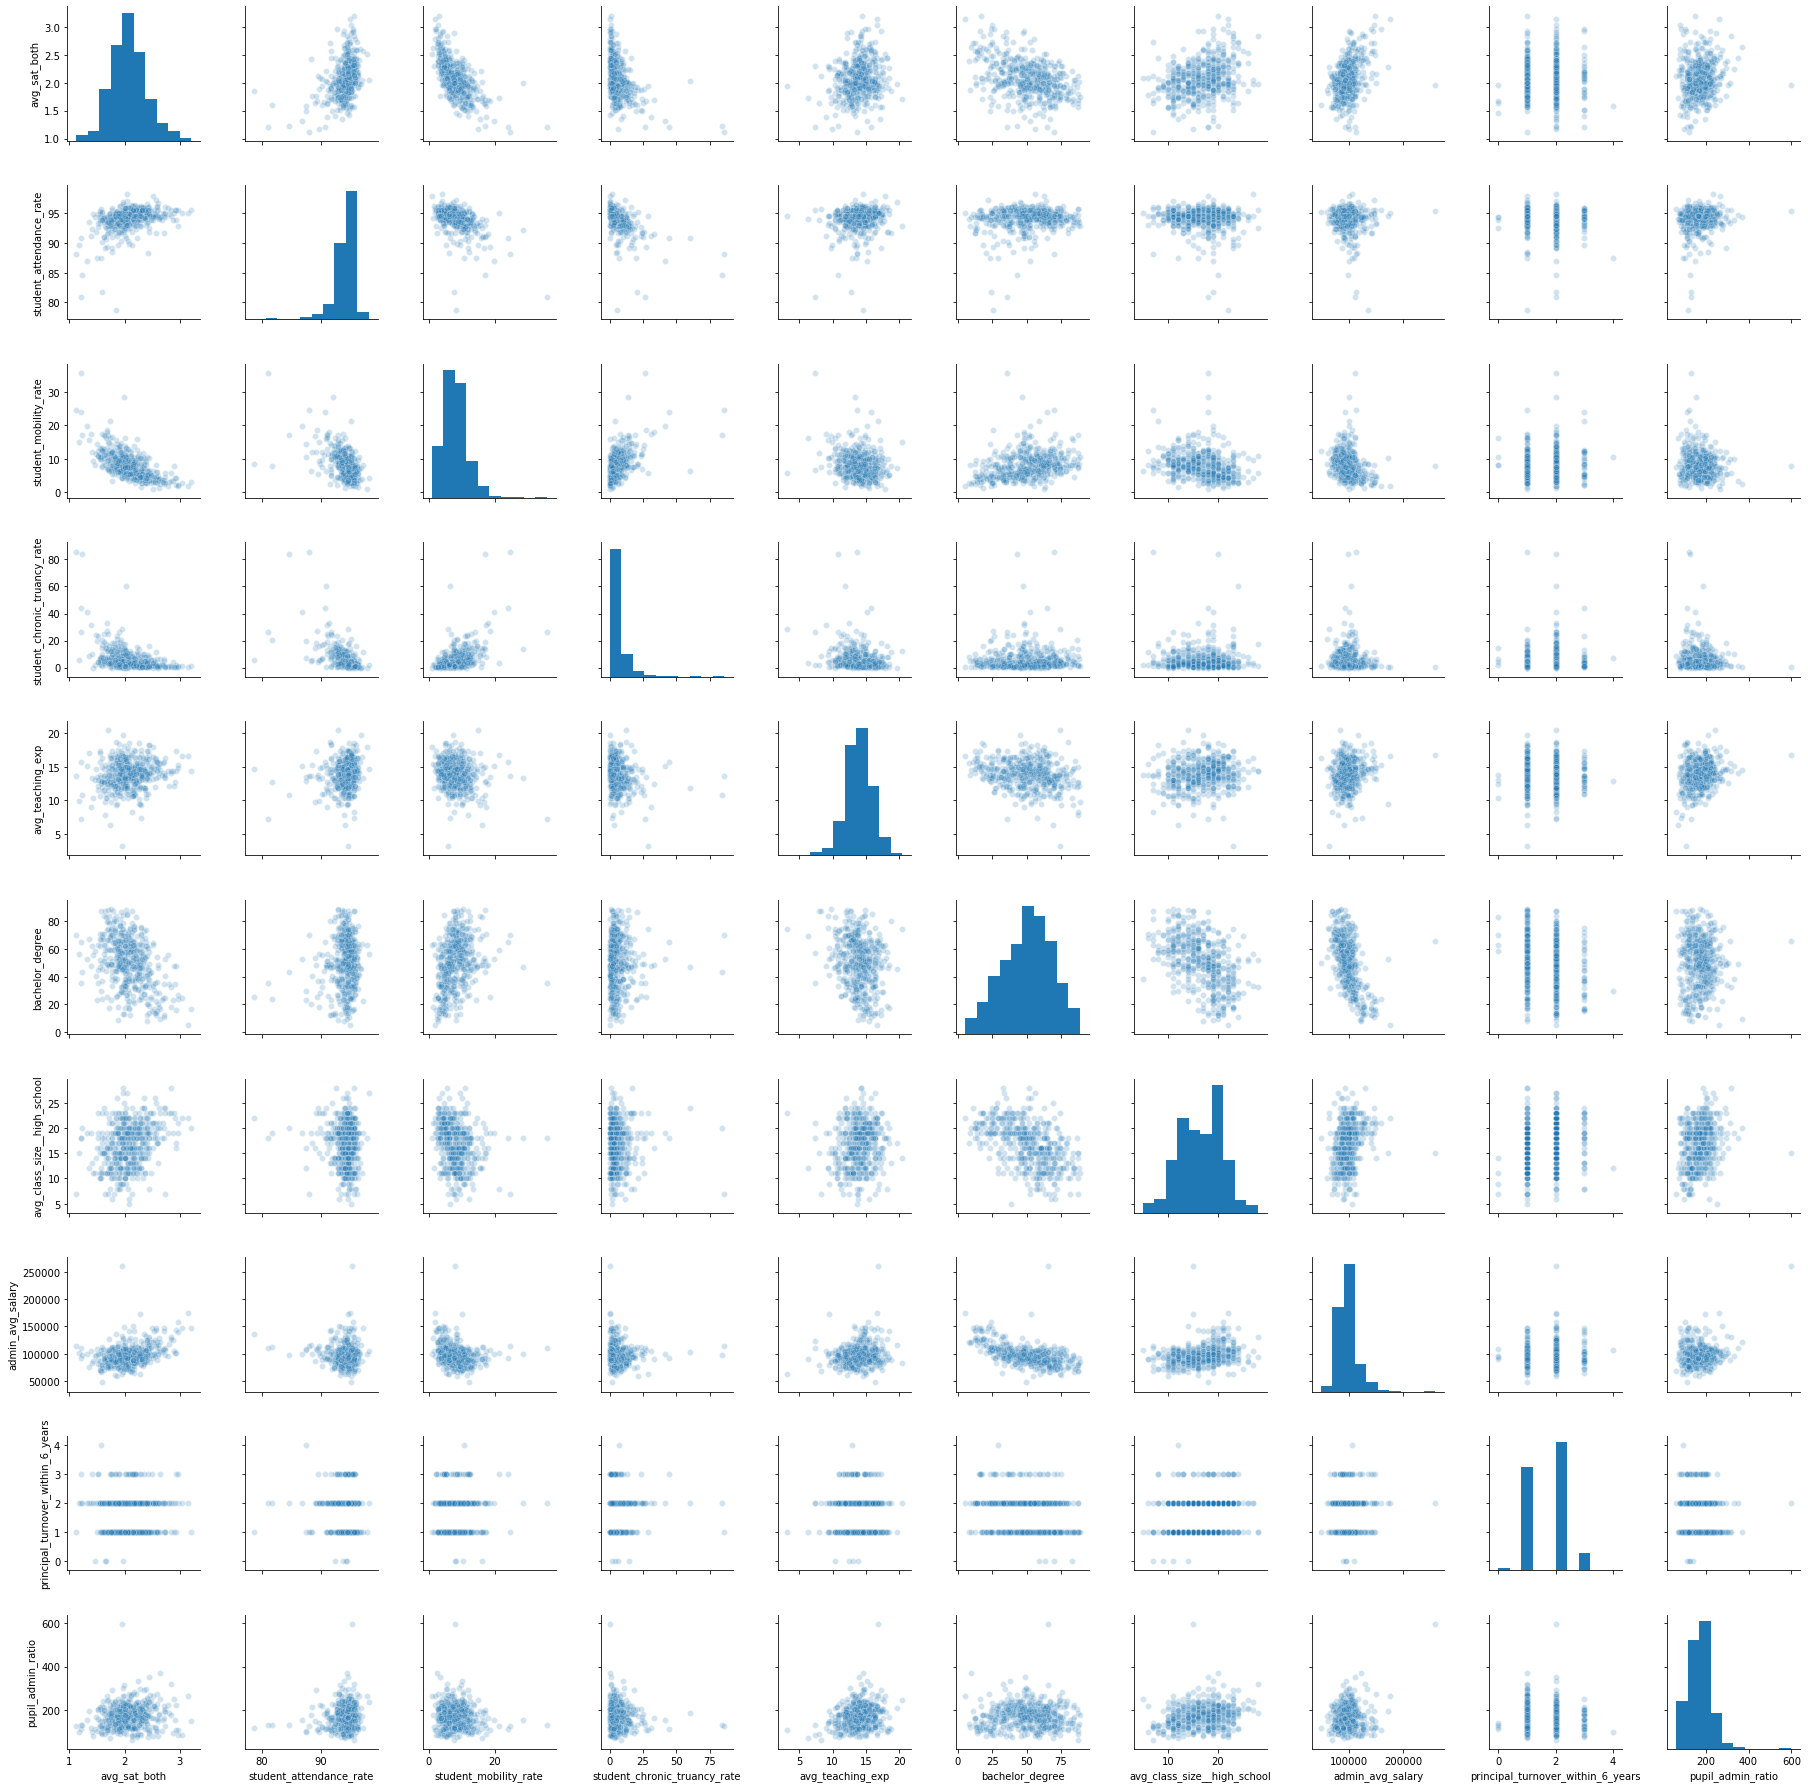

In [15]:
eda_column_subset(raw, [ind_var] + second + fourth)

In [16]:
# nothing looks crazy

avg_sat_both  pupil_teacher_ratio__high_school  teacher_retention_rate  \
count    473.000000                        472.000000              472.000000   
mean       2.072638                         15.781568               86.705720   
std        0.324883                          4.479581                6.573358   
min        1.125000                          5.100000               56.000000   
10%        1.683900                          9.600000               78.220000   
25%        1.872500                         12.600000               83.500000   
50%        2.047500                         16.250000               88.100000   
75%        2.269000                         18.925000               91.500000   
90%        2.473600                         20.980000               93.400000   
max        3.204500                         33.900000               99.000000   

       teacher_attendace_rate  inst_and_support  \
count              468.000000        468.000000   
mean                72.632051         75.273504   
std                 12.425387         10.221597   
min                  1.800000         20.900000   
10%                 57.140000         63.010000   
25%                 66.175000         70.300000   
50%                 73.700000         77.200000   
75%                 80.725000         82.200000   
90%                 87.130000         85.800000   
max                100.000000         92.100000   

       %_ebf_capacity_to_meet_expectations  avg_class_size__high_school  \
count                           468.000000                   473.000000   
mean                             74.243376                    16.640592   
std                              22.175654                     4.341098   
min                              47.000000                     5.000000   
10%                              56.870000                    11.000000   
25%                              60.800000                    14.000000   
50%                              67.800000                    17.000000   
75%                              78.800000                    20.000000   
90%                             100.980000                    22.000000   
max                             198.000000                    28.000000   

       admin_avg_salary  principal_turnover_within_6_years  pupil_admin_ratio  
count        472.000000                         472.000000         472.000000  
mean       97757.144386                           1.644068         172.987076  
std        18801.927792                           0.628758          53.834771  
min        47470.670000                           0.000000          62.500000  
10%        78295.262000                           1.000000         110.020000  
25%        86191.665000                           1.000000         134.675000  
50%        95901.665000                           2.000000         172.350000  
75%       105911.262500                           2.000000         204.100000  
90%       118230.650000                           2.000000         234.390000  
max       260021.320000                           4.000000         597.000000

<Figure size 2880x2880 with 0 Axes>

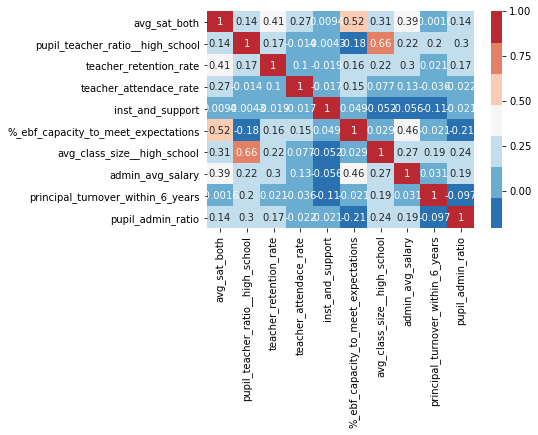

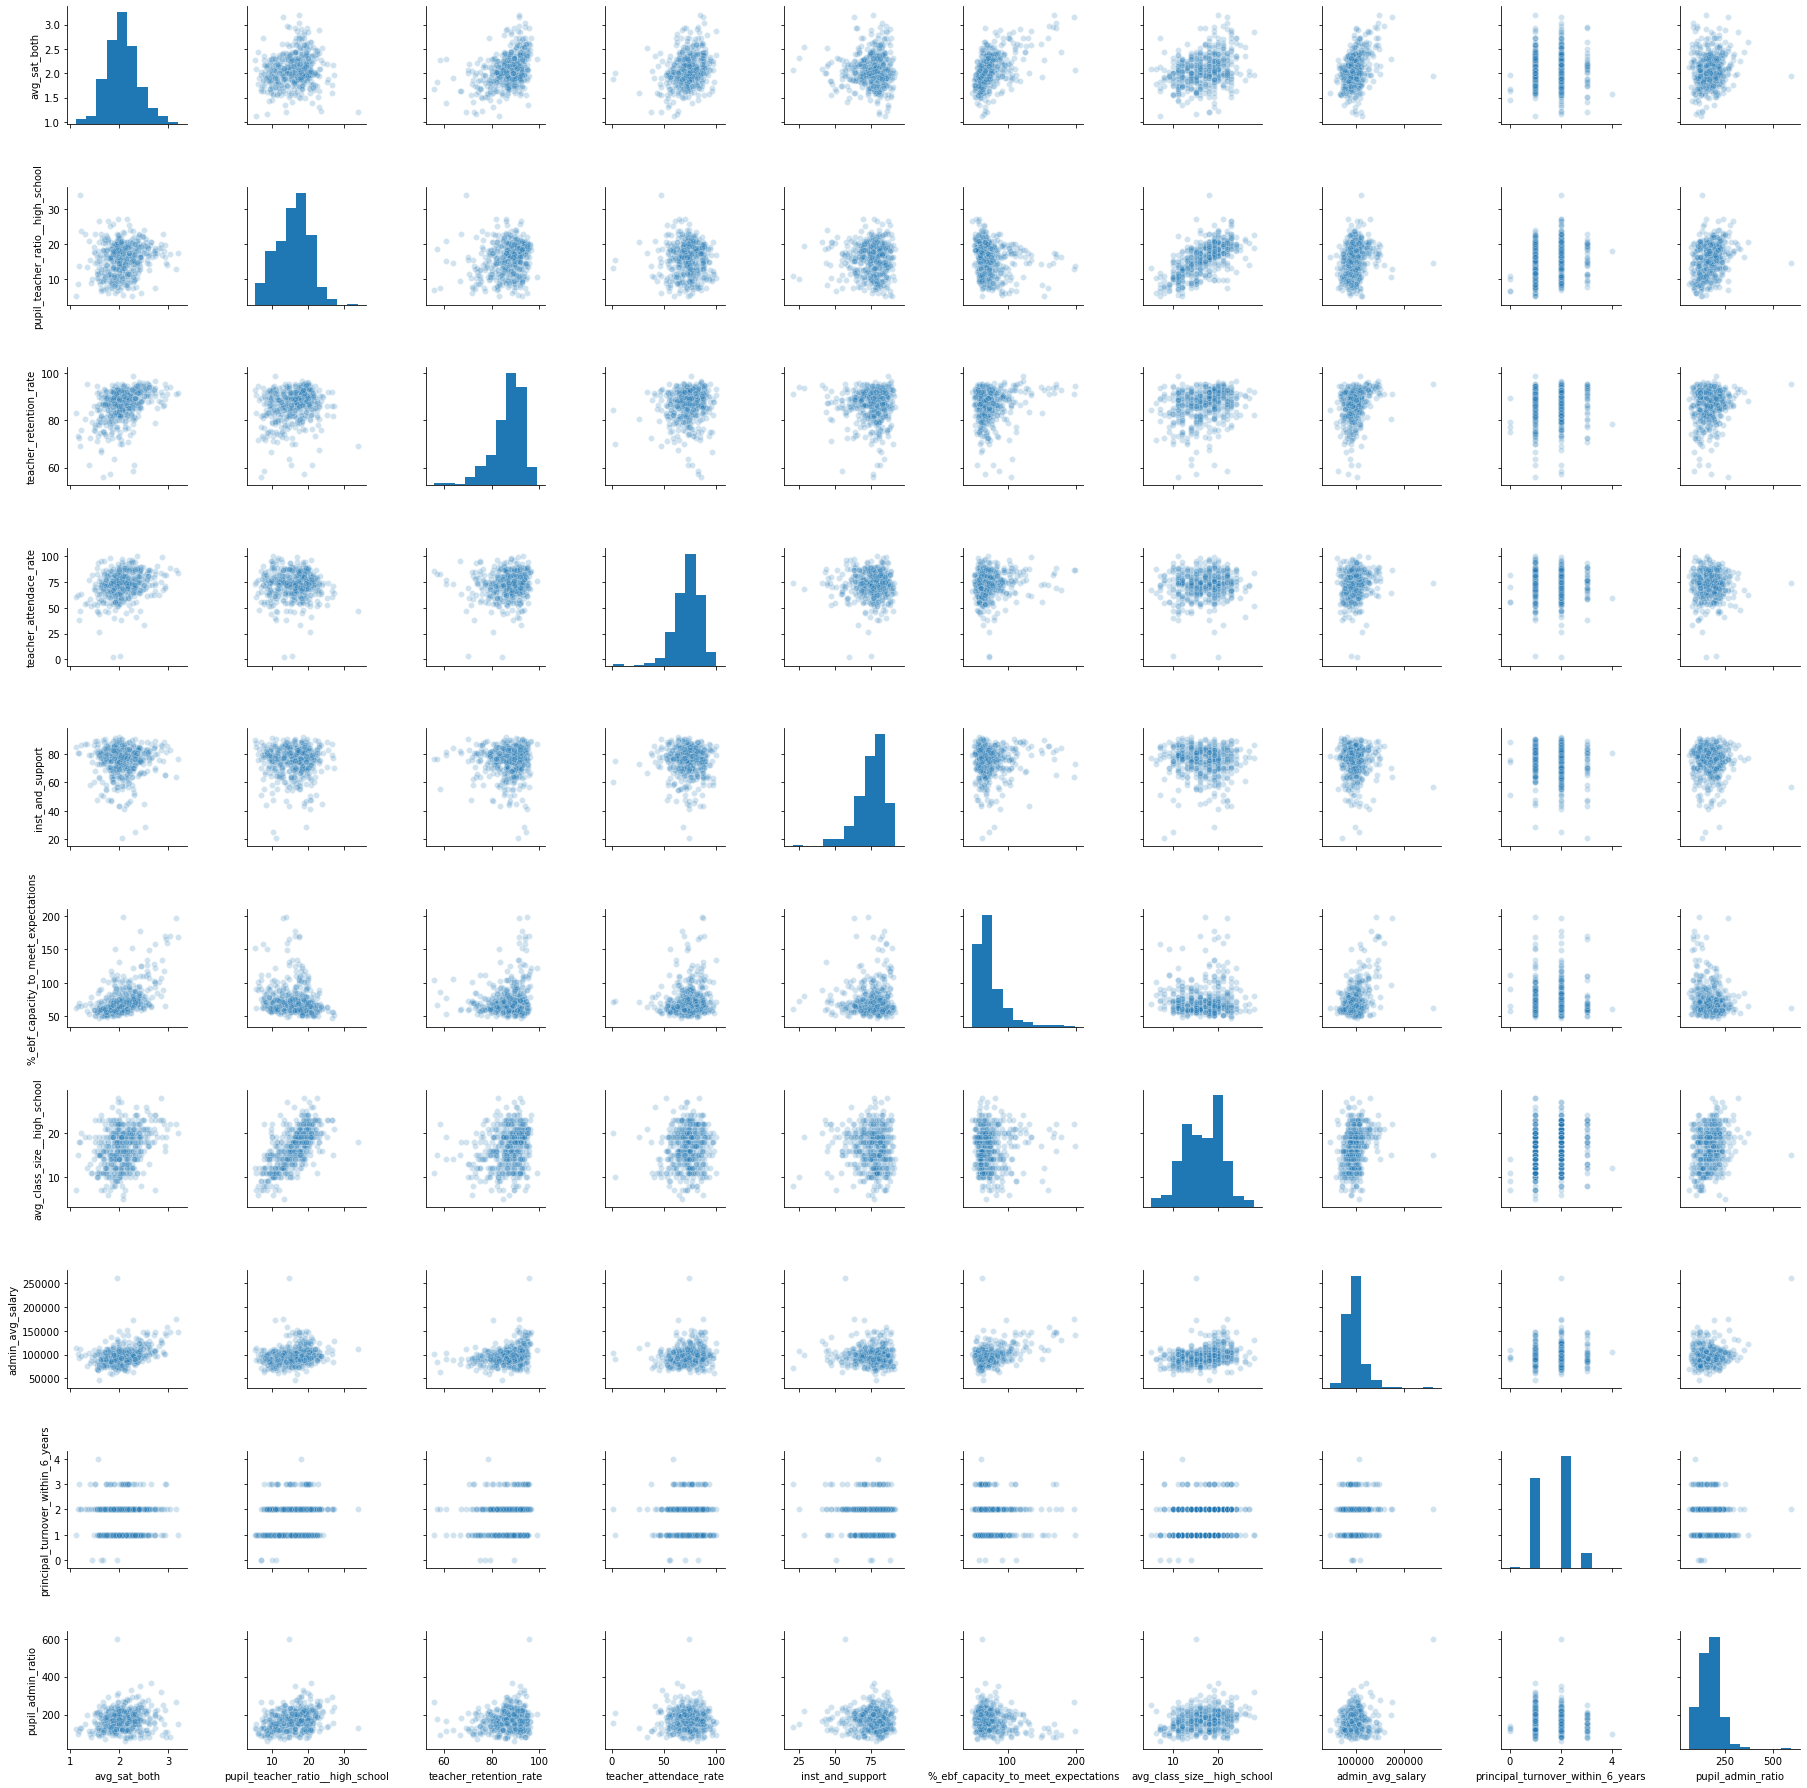

In [17]:
eda_column_subset(raw, [ind_var] + third + fourth)

In [18]:
# probably pick one of pupil-teacher vs avg-class-size (class size better)

In [19]:
# CONCLUSIONS

# How to handle nulls:
    # Drop Column:
        # principle_turnover (low var, low corr with sat)
        # inst_support (low corr with sat, corr with other stuff)
        # pupil_teacher_ratio (prefer avg clas size)
        # district_type (domain knowledge -> unlikely to matter)
    # mean:
        # avg_teach_exp (norm dist, low corr with other var)
        # pupil_admin_ratio (norm dist, low corr with other var)
    # mean or k-nearest:
        # bachelor_deg
        # teacher_retention
        # teacher_attendence
        # admin_salary 
            # might just use mean for first pass
    # k-nearest:
        # %ebf (highly corr with low_inc, h corr with sat)
            # might just drop for first pass
        
# Outliers:
    # Homeless/Low Income District -> drop
    # High Sal / Few Staff District -> drop
    # Teacher attendence near zero -> correct to mean/k-nearest
    
# Feature Engineering:
    # Might be poly relationship btwn mobility and sat
    
# Incorrect Null Handling
    # I think there are some suspect 0 values for "%_student" vals (TD)

# Data Cleaning

In [20]:
for_model = clean_data(raw)

In [21]:
for_model.head()

avg_sat_both  num_student_enrollment  perc_student_enrollment__homeless  \
0        2.1735                   559.0                                0.0   
1        2.0865                   602.0                                0.0   
2        2.0270                   874.0                                0.0   
3        2.1525                   674.0                                0.0   
4        1.9970                  6469.0                                1.0   

   perc_student_enrollment__low_income  perc_student_enrollment__iep  \
0                                 48.8                          17.9   
1                                 24.9                          15.3   
2                                 46.7                          18.6   
3                                 20.2                          17.2   
4                                 60.7                          18.7   

   perc_student_enrollment__el  student_attendance_rate  \
0                          0.0                     95.6   
1                          0.0                     95.6   
2                          0.0                     94.8   
3                          0.0                     94.9   
4                          0.3                     92.8   

   student_mobility_rate  student_chronic_truancy_rate  avg_teaching_exp  \
0                    4.5                           4.0              11.5   
1                    3.3                           0.9              13.5   
2                    5.9                           3.3              12.5   
3                    5.7                           2.1              14.1   
4                   10.9                          13.7              12.0   

   bachelor_degree  teacher_retention_rate  teacher_attendace_rate  \
0             56.3                    92.9                    63.8   
1             41.9                    91.5                    57.7   
2             42.9                    81.3                    81.0   
3             61.3                    89.7                    77.6   
4             56.9                    73.6                    78.7   

   perc_ebf_capacity_to_meet_expectations  avg_class_size__high_school  \
0                                    59.4                         13.0   
1                                    66.7                         22.0   
2                                    62.3                         15.0   
3                                    68.1                         11.0   
4                                    69.8                         20.0   

   admin_avg_salary  pupil_admin_ratio  
0          72141.72              139.8  
1          83605.24              200.7  
2          75068.50              145.7  
3          83692.00              134.8  
4          82764.57              205.4

# Model

## Split Into Train and Test

In [22]:
X, y = for_model.drop(columns=[ind_var]), for_model[ind_var]

In [23]:
rand_state = find_consistent_train_test_split(X, y, test_size=.2, display_top_ten=True)

[(74, 0.0434539950933246), (60, 0.05670532201835541), (95, 0.06143735949243732), (88, 0.08178120996371573), (10, 0.08254142637142332), (17, 0.08964919519599471), (3, 0.09638745395191364), (37, 0.09647023055958107), (65, 0.09769575833550286), (85, 0.09861753462629984)]


In [24]:
rand_state = 71 # for consistency with first run

In [25]:
# TD - use rand_state var
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)

In [26]:
validate_train_test_split(X_train, X_test, y_train, y_test)

***** Diff Btwn Mean of Train vs. Test (in std) *****
***** Features *****
num_student_enrollment: 0.028429022744112558
perc_student_enrollment__homeless: 0.06818221557544979
perc_student_enrollment__low_income: 0.07818116838583548
perc_student_enrollment__iep: -0.15261190792319695
perc_student_enrollment__el: -0.04797868851859678
student_attendance_rate: 0.018181819480818255
student_mobility_rate: -0.09676974721956522
student_chronic_truancy_rate: 0.020239150228898224
avg_teaching_exp: -0.08578058763127859
bachelor_degree: -0.1165528850850736
teacher_retention_rate: -0.02448236131224602
teacher_attendace_rate: 0.1109744739772672
perc_ebf_capacity_to_meet_expectations: 0.06595352942737422
avg_class_size__high_school: 0.06054234801602678
admin_avg_salary: 0.0051012593880661325
pupil_admin_ratio: -0.16591662195104712
***** Ind Var *****
-0.04939473768747445


## K-Folds Simple Linear Model

R2 (in sample): 0.70806 +- 0.01117
R2: 0.65944 +- 0.04584
Mean Sq Error: 0.03417 +- 0.00715
Mean abs error: 0.14250 +- 0.01643
AIC (in sample): -167.28770 +- 16.29629
                            OLS Regression Results                            
Dep. Variable:           avg_sat_both   R-squared:                       0.704
Model:                            OLS   Adj. R-squared:                  0.691
Method:                 Least Squares   F-statistic:                     52.18
Date:                Thu, 23 Jan 2020   Prob (F-statistic):           1.67e-82
Time:                        16:47:03   Log-Likelihood:                 122.81
No. Observations:                 368   AIC:                            -211.6
Df Residuals:                     351   BIC:                            -145.2
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
                                           

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

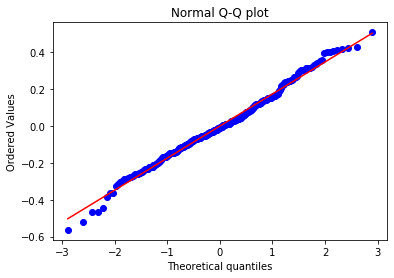

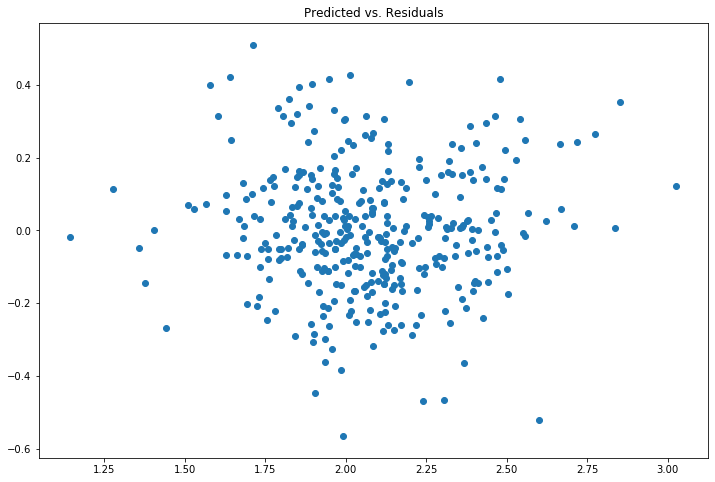

In [27]:
cross_val(X_train, y_train, model=LinearRegression, sm_summary=True, resid_plots=True)

In [28]:
# Initial Reactions
    # seems fairly consistent (not crazy overfitted)
    # R2, mse, AIC all seem reasonably good
    # Decent first model
    # model def means something - F stat p-value is super low

# 5 assumptions

# linear and correctly specified -> PROBABLY FINE
# no serial correlation -> CHECK
    # DW between 1.5 nand 2.5 is the standard (mine is 1.8)
# no multicollinearity -> IT DIDN'T BREAK SO PROB OK-ISH
    # Condition number is huge tho (implying not very stable to changes in metrics)
# no heteroskedasticity -> SEEMS GOOD
    # visual plot of residuals looks fine
# normal errors -> SOME NON-NORMALCY BUT NOT A LOT
    # Omnibus measures normality -> null hyp is that it IS normal (no skew, no EXCESSIVE kurtosis)
        # Since p-value is 0.09, can't reject that it's normal at a 5% threshold
        # Omnnibus says I'm close to non-normalcy but fine
    # JB also tests normality (has same null hyp -> that is IS normal)
        # my p-value is just barely over 0.05 (so can't reject but clos)
        # would pref skew ~ 0 and kurtosis ~ 3 (mine are 0.07 and 3.5)
            # so prob have a little kurtosis but not blatantly bad (matches QQ graph)
    # Visually, seems like a little kurtosis

# Goodness of fit:
    # log-liklihood is positive (higher the better)
    # AIC/BIC both negative (lower the better)

# General Observations

# wrong sign for teacher_exp and bachelors_deg (multicollinearity?)
# avg_class_size has "wrong" sign (altho wouldn't be surprised if it was low coeff)
# a bunch of coefficients have high p-values (perhaps all the collinearity)
    # between mobility, low_inc, teacher ret, teacher bach, teacher attend

# Take Aways
# I think a linear regression is valid (assumptions basically hold)
# Seems like a reasonably good fit
# I suspect I have some multicollinearity going on (not surprising given the # of features and how inter-corr they are)
# Prob making coeff weird
    # Given that interpretability is big part of my goals, would like to try and improve MC
    
# Main Goals:
    # address possible MC
    # Consider dropping:
        # teacher attendence
        # student truancy
        # homeless
        # iep
        # bachelor
        # admin salary

## Address MC

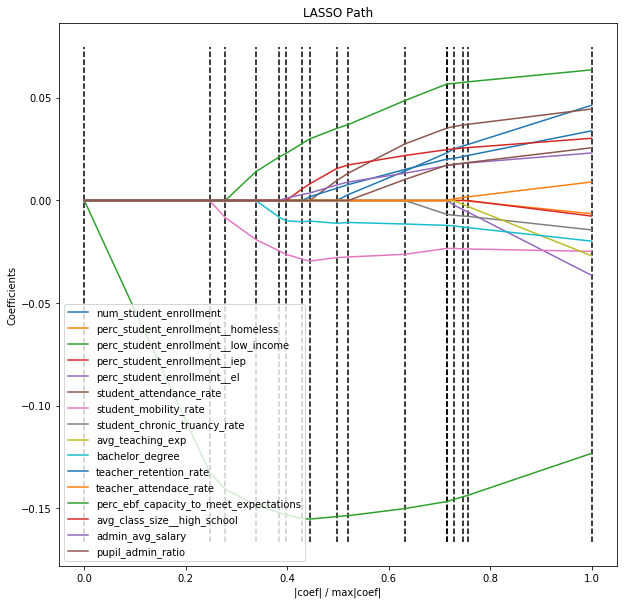

In [29]:
generate_LARS_plot(X_train, y_train)

In [30]:
# list of features with low p-val with LARS rank:
        # teacher attendence (t-1)
        # student truancy (6)
        # homeless (t-1)
        # iep (t-1)
        # bachelor (4th to last) -> keep this one?
        # admin salary (t-first)
# Lasso also indicates remove teaching_exp
    # "wrong" sign
    # very small value
    # perhaps MC with other things?
        # visually reviewed correl heat maps
        # somewhat with teacher-retention (.42)
        # slightly negatively correl with lots of student demographics

## Remove LARS Features and Compare

### Remove Worst 6

In [31]:
lasso_columns_remove = [
        'perc_student_enrollment__homeless',
        'perc_student_enrollment__iep',
        'teacher_attendace_rate',
        'admin_avg_salary',
        'student_chronic_truancy_rate',
        'avg_teaching_exp'
    ]

In [32]:
# Prev best model
cross_val(X_train, y_train, model=LinearRegression)

R2 (in sample): 0.70806 +- 0.01117
R2: 0.65944 +- 0.04584
Mean Sq Error: 0.03417 +- 0.00715
Mean abs error: 0.14250 +- 0.01643
AIC (in sample): -167.28770 +- 16.29629


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

R2 (in sample): 0.69647 +- 0.01313
R2: 0.66414 +- 0.05753
Mean Sq Error: 0.03375 +- 0.00783
Mean abs error: 0.14319 +- 0.01903
AIC (in sample): -167.88796 +- 17.02848
                            OLS Regression Results                            
Dep. Variable:           avg_sat_both   R-squared:                       0.694
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     80.94
Date:                Thu, 23 Jan 2020   Prob (F-statistic):           1.74e-85
Time:                        16:47:04   Log-Likelihood:                 116.64
No. Observations:                 368   AIC:                            -211.3
Df Residuals:                     357   BIC:                            -168.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                           

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

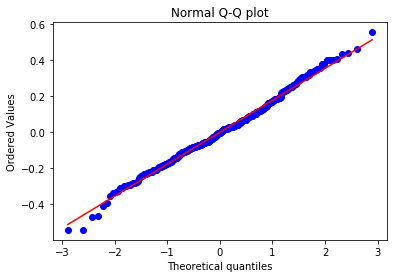

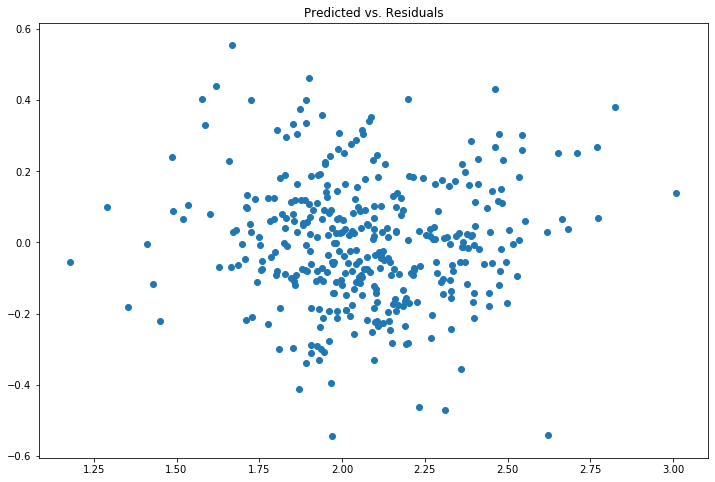

In [33]:
# Dropping LARS columns
cross_val(X_train, y_train, model=LinearRegression, drop_cols=lasso_columns_remove, sm_summary=True, resid_plots=True)

In [34]:
# remarkably similar
    # slightly better metrics
    # slightly more variance
# prefer the simpler one with fewer features if they're basically identical
# stats profile and resids still look good
# A few of the variables are no statistically significant
# Condition number reduced by an order of magnitude
# Bachelor's degree still has "wrong" sign

### Remove Next Worst 4

In [35]:
cross_val(X_train, y_train, model=LinearRegression, drop_cols=lasso_columns_remove)

R2 (in sample): 0.69647 +- 0.01313
R2: 0.66414 +- 0.05753
Mean Sq Error: 0.03375 +- 0.00783
Mean abs error: 0.14319 +- 0.01903
AIC (in sample): -167.88796 +- 17.02848


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

R2 (in sample): 0.66048 +- 0.01181
R2: 0.62957 +- 0.04899
Mean Sq Error: 0.03716 +- 0.00781
Mean abs error: 0.15104 +- 0.01875
AIC (in sample): -142.80741 +- 15.44450
                            OLS Regression Results                            
Dep. Variable:           avg_sat_both   R-squared:                       0.658
Model:                            OLS   Adj. R-squared:                  0.653
Method:                 Least Squares   F-statistic:                     115.9
Date:                Thu, 23 Jan 2020   Prob (F-statistic):           5.02e-81
Time:                        16:47:04   Log-Likelihood:                 96.335
No. Observations:                 368   AIC:                            -178.7
Df Residuals:                     361   BIC:                            -151.3
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                           

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

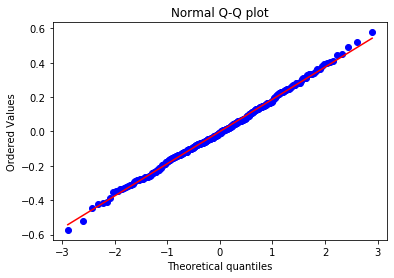

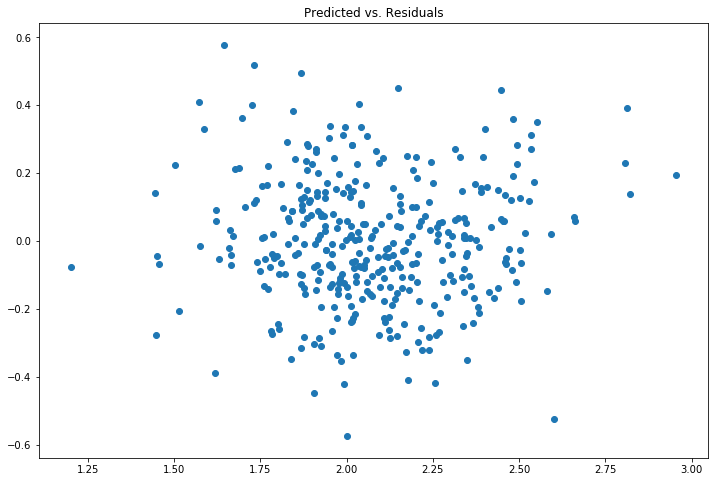

In [36]:
cross_val(X_train, y_train, model=LinearRegression, drop_cols=lasso_columns_remove + [
    'num_student_enrollment',
    'student_attendance_rate',
    'teacher_retention_rate',
    'pupil_admin_ratio',
], sm_summary=True, resid_plots=True)

In [37]:
# removing any of the above columns (the next 4 in LARS) makes the model a little worse

In [38]:
# Bachelor and class size remain the "wrong" sign
    # altho bachelor is not sig so basically zero
# The condition number went down two orders of magnitude

**CONCLUSION**

Removing `lasso_columns_remove` definitely helped the model

Seems like remvoing additional individual metrics in addition doesn't hurt much

## EDA Again With Fewer Features

In [39]:
post_lasso_cols = list(set(for_model.columns) - set(lasso_columns_remove))

perc_ebf_capacity_to_meet_expectations  teacher_retention_rate  \
count                              461.000000              461.000000   
mean                                74.126898               86.826681   
std                                 21.966172                6.470398   
min                                 47.000000               56.000000   
10%                                 56.800000               78.700000   
25%                                 60.700000               83.700000   
50%                                 67.700000               88.200000   
75%                                 78.800000               91.500000   
90%                                100.800000               93.400000   
max                                198.000000               99.000000   

       num_student_enrollment  avg_sat_both  perc_student_enrollment__el  \
count              461.000000    461.000000                   461.000000   
mean              2345.542299      2.075922                     2.500651   
std               3950.032412      0.319787                     5.625831   
min                124.000000      1.125000                     0.000000   
10%                356.000000      1.695000                     0.000000   
25%                545.000000      1.873000                     0.000000   
50%               1010.000000      2.049500                     0.000000   
75%               2253.000000      2.269000                     2.300000   
90%               5693.000000      2.477000                     7.700000   
max              38764.000000      3.204500                    39.000000   

       perc_student_enrollment__low_income  bachelor_degree  \
count                           461.000000       461.000000   
mean                             42.491757        50.388937   
std                              18.257985        18.079820   
min                               2.100000         5.200000   
10%                              17.900000        24.700000   
25%                              29.600000        37.700000   
50%                              42.600000        51.500000   
75%                              53.800000        63.200000   
90%                              63.400000        73.100000   
max                              99.600000        88.900000   

       student_mobility_rate  pupil_admin_ratio  student_attendance_rate  \
count             461.000000         461.000000               461.000000   
mean                8.055965         173.529067                94.095445   
std                 3.618214          53.515202                 1.850993   
min                 1.000000          62.500000                78.700000   
10%                 3.900000         111.200000                92.300000   
25%                 5.400000         136.300000                93.600000   
50%                 7.700000         173.300000                94.500000   
75%                10.100000         204.400000                95.100000   
90%                12.400000         234.400000                95.700000   
max                28.600000         597.000000                98.200000   

       avg_class_size__high_school  
count                   461.000000  
mean                     16.626898  
std                       4.335853  
min                       5.000000  
10%                      11.000000  
25%                      14.000000  
50%                      17.000000  
75%                      20.000000  
90%                      22.000000  
max                      28.000000

<Figure size 2880x2880 with 0 Axes>

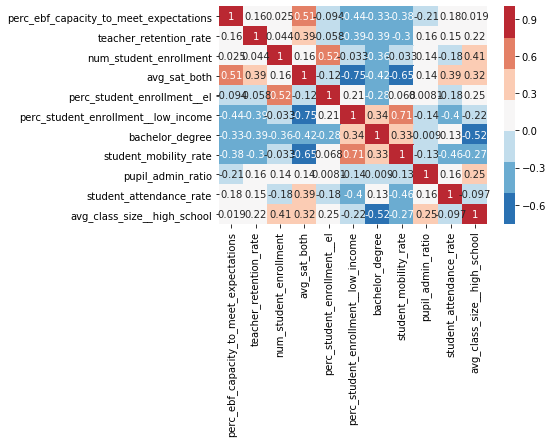

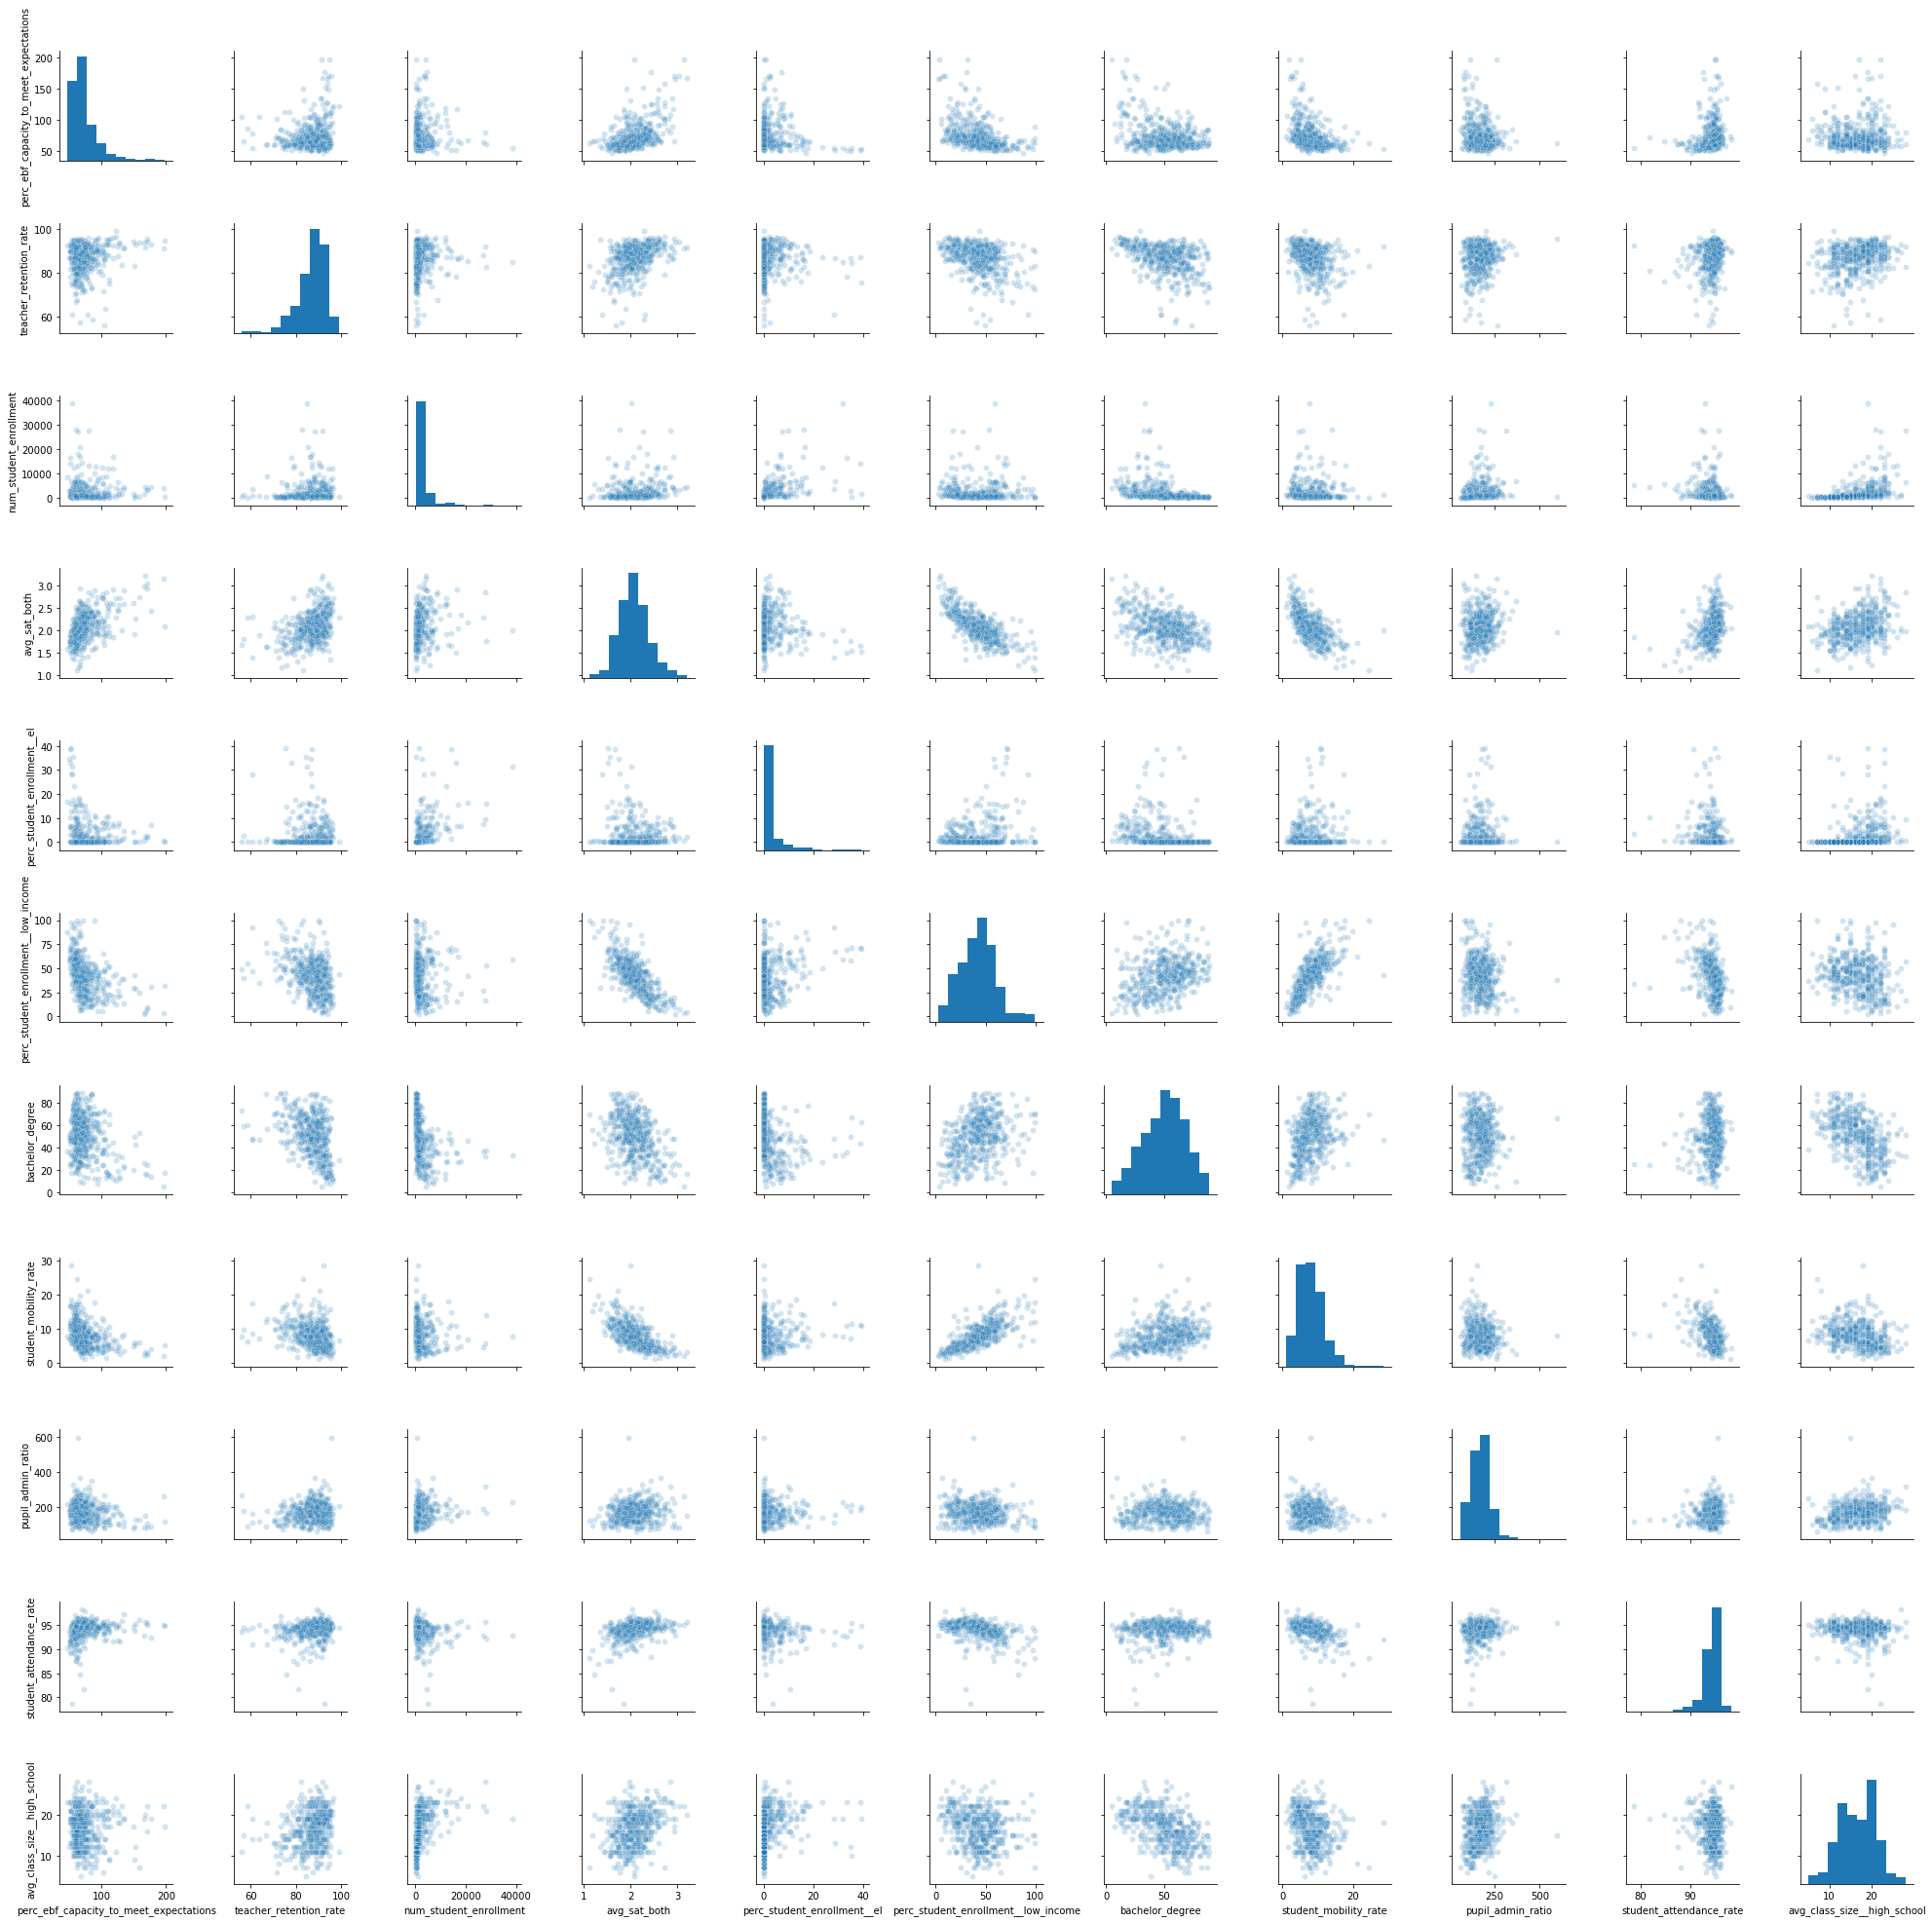

In [40]:
eda_column_subset(for_model, post_lasso_cols)

In [41]:
# Possible Transformations:
    # log student enrollment, %_el, %_ebf
    # deg2 poly mobility, bachelor deg
# Makes sense that I have a high condition score
    # Heat map still pretty colored
# Mobility and low_income rates have a high correlation with each other (.7)
    # Nothing else much beyond .5

## Does Regularization Help?

### Ridge

In [42]:
for a in [x for x in range(10, 50)]:
    print(f'********** Alpha: {a} **********')
    cross_val(
        X_train,
        y_train,
        model=Ridge,
        alpha=a,
        standardize=True,
        drop_cols=lasso_columns_remove
    )

********** Alpha: 10 **********
R2 (in sample): 0.69614 +- 0.01315
R2: 0.66540 +- 0.05599
Mean Sq Error: 0.03366 +- 0.00783
Mean abs error: 0.14330 +- 0.01923
AIC (in sample): -167.88796 +- 17.02848
********** Alpha: 11 **********
R2 (in sample): 0.69608 +- 0.01316
R2: 0.66549 +- 0.05583
Mean Sq Error: 0.03366 +- 0.00783
Mean abs error: 0.14331 +- 0.01925
AIC (in sample): -167.88796 +- 17.02848
********** Alpha: 12 **********
R2 (in sample): 0.69601 +- 0.01316
R2: 0.66557 +- 0.05568
Mean Sq Error: 0.03365 +- 0.00783
Mean abs error: 0.14333 +- 0.01927
AIC (in sample): -167.88796 +- 17.02848
********** Alpha: 13 **********
R2 (in sample): 0.69594 +- 0.01317
R2: 0.66564 +- 0.05553
Mean Sq Error: 0.03365 +- 0.00783
Mean abs error: 0.14335 +- 0.01929
AIC (in sample): -167.88796 +- 17.02848
********** Alpha: 14 **********
R2 (in sample): 0.69587 +- 0.01317
R2: 0.66571 +- 0.05538
Mean Sq Error: 0.03364 +- 0.00783
Mean abs error: 0.14337 +- 0.01932
AIC (in sample): -167.88796 +- 17.02848
*****

In [43]:
ridge_alpha = 23

In [44]:
# previous best model => no ridge
cross_val(X_train, y_train, model=LinearRegression, drop_cols=lasso_columns_remove)

R2 (in sample): 0.69647 +- 0.01313
R2: 0.66414 +- 0.05753
Mean Sq Error: 0.03375 +- 0.00783
Mean abs error: 0.14319 +- 0.01903
AIC (in sample): -167.88796 +- 17.02848


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [45]:
last_ridge = cross_val(
    X_train,
    y_train,
    model=Ridge,
    standardize=True,
    alpha=ridge_alpha,
    drop_cols=lasso_columns_remove
)

R2 (in sample): 0.69502 +- 0.01322
R2: 0.66608 +- 0.05403
Mean Sq Error: 0.03363 +- 0.00784
Mean abs error: 0.14358 +- 0.01954
AIC (in sample): -167.88796 +- 17.02848


In [46]:
# pretty damn similar

In [47]:
print_coef(columns=X_train.drop(columns=lasso_columns_remove).columns, coefs=last_ridge.coef_)

perc_student_enrollment__low_income: -0.13330706799778505
perc_ebf_capacity_to_meet_expectations: 0.06710642262331426
student_attendance_rate: 0.0443691326632142
student_mobility_rate: -0.03952821728962876
num_student_enrollment: 0.039183129488857375
avg_class_size__high_school: 0.029964181875971017
teacher_retention_rate: 0.02442860064522929
bachelor_degree: -0.019912060751332825
perc_student_enrollment__el: -0.01872058727203952
pupil_admin_ratio: 0.018706529033176333


In [48]:
# ^^^ relative importance of variables

### LASSO

In [49]:
for a in [x/2000 for x in range(0, 20)]:
    print(f'********** Alpha: {a} **********')
    cross_val(
        X_train,
        y_train,
        model=Lasso,
        standardize=True,
        alpha=a,
        drop_cols=lasso_columns_remove
    )

********** Alpha: 0.0 **********
R2 (in sample): 0.00000 +- 0.00000
R2: -0.00535 +- 0.00378
Mean Sq Error: 0.10162 +- 0.02222
Mean abs error: 0.24650 +- 0.02570
AIC (in sample): -167.88796 +- 17.02848
********** Alpha: 0.0005 **********
R2 (in sample): 0.69645 +- 0.01313
R2: 0.66428 +- 0.05671
Mean Sq Error: 0.03374 +- 0.00780
Mean abs error: 0.14319 +- 0.01903
AIC (in sample): -167.88796 +- 17.02848
********** Alpha: 0.001 **********
R2 (in sample): 0.69639 +- 0.01313
R2: 0.66438 +- 0.05589
Mean Sq Error: 0.03374 +- 0.00777
Mean abs error: 0.14318 +- 0.01903
AIC (in sample): -167.88796 +- 17.02848
********** Alpha: 0.0015 **********
R2 (in sample): 0.69630 +- 0.01313
R2: 0.66444 +- 0.05508
Mean Sq Error: 0.03373 +- 0.00774
Mean abs error: 0.14318 +- 0.01903
AIC (in sample): -167.88796 +- 17.02848
********** Alpha: 0.002 **********
R2 (in sample): 0.69617 +- 0.01314
R2: 0.66445 +- 0.05427
Mean Sq Error: 0.03374 +- 0.00771
Mean abs error: 0.14317 +- 0.01904
AIC (in sample): -167.88796 +

In [50]:
lasso_alpha = 0.0015

In [51]:
# prev best
cross_val(X_train, y_train, model=LinearRegression, drop_cols=lasso_columns_remove)

R2 (in sample): 0.69647 +- 0.01313
R2: 0.66414 +- 0.05753
Mean Sq Error: 0.03375 +- 0.00783
Mean abs error: 0.14319 +- 0.01903
AIC (in sample): -167.88796 +- 17.02848


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [52]:
# with ridge
last_ridge = cross_val(
    X_train,
    y_train,
    model=Ridge,
    standardize=True,
    alpha=ridge_alpha,
    drop_cols=lasso_columns_remove
)

R2 (in sample): 0.69502 +- 0.01322
R2: 0.66608 +- 0.05403
Mean Sq Error: 0.03363 +- 0.00784
Mean abs error: 0.14358 +- 0.01954
AIC (in sample): -167.88796 +- 17.02848


In [53]:
last_lasso = cross_val(
    X_train,
    y_train,
    model=Lasso,
    standardize=True,
    alpha=lasso_alpha,
    drop_cols=lasso_columns_remove
)

R2 (in sample): 0.69630 +- 0.01313
R2: 0.66444 +- 0.05508
Mean Sq Error: 0.03373 +- 0.00774
Mean abs error: 0.14318 +- 0.01903
AIC (in sample): -167.88796 +- 17.02848


In [54]:
# Ridge appears to be every so slightly better

In [55]:
print_coef(columns=X_train.drop(columns=lasso_columns_remove).columns, coefs=last_lasso.coef_)

perc_student_enrollment__low_income: -0.15179044914718343
perc_ebf_capacity_to_meet_expectations: 0.06818944701735205
student_attendance_rate: 0.04309048919519374
num_student_enrollment: 0.039648337845069895
avg_class_size__high_school: 0.031192916109015804
student_mobility_rate: -0.031131859686827804
teacher_retention_rate: 0.022484305915433943
pupil_admin_ratio: 0.016898634634454388
perc_student_enrollment__el: -0.014622533392572775
bachelor_degree: -0.014541038716088951


In [56]:
# very similar to Ridge
    # top 4 are exactly the same
    # next two are just flip flopped order
        # wonder what a model with just those six would look like

**CONCLUSION**

Regularization was marginally better

Given focus on interprability, will refrain from regularization

## Super Sparse Model

In [57]:
top_six = [
    'perc_student_enrollment__low_income',
    'perc_ebf_capacity_to_meet_expectations',
    'student_attendance_rate',
    'num_student_enrollment',
    'avg_class_size__high_school',
    'student_mobility_rate'
]

In [58]:
top_six_complement = list(set(X_train.columns) - set(top_six))

In [59]:
cross_val(X_train, y_train, model=LinearRegression, drop_cols=lasso_columns_remove)

R2 (in sample): 0.69647 +- 0.01313
R2: 0.66414 +- 0.05753
Mean Sq Error: 0.03375 +- 0.00783
Mean abs error: 0.14319 +- 0.01903
AIC (in sample): -167.88796 +- 17.02848


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [60]:
cross_val(X_train, y_train, model=LinearRegression, drop_cols=top_six_complement, sm_summary=True)

R2 (in sample): 0.67800 +- 0.01227
R2: 0.65099 +- 0.04866
Mean Sq Error: 0.03494 +- 0.00724
Mean abs error: 0.14587 +- 0.01885
AIC (in sample): -158.44338 +- 14.94978
                            OLS Regression Results                            
Dep. Variable:           avg_sat_both   R-squared:                       0.676
Model:                            OLS   Adj. R-squared:                  0.671
Method:                 Least Squares   F-statistic:                     125.7
Date:                Thu, 23 Jan 2020   Prob (F-statistic):           3.05e-85
Time:                        16:47:35   Log-Likelihood:                 106.29
No. Observations:                 368   AIC:                            -198.6
Df Residuals:                     361   BIC:                            -171.2
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                           

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [61]:
# Definitely a little worse

In [62]:
# p values are nice
# still have a high condintion number
# nothing flipped sign

# Probably still like the old model

## Feature Engineering

### Polynomials

In [63]:
X_train_poly = X_train.copy()
X_train_poly['bachelor_sq'] = X_train_poly['bachelor_degree'] ** 2
X_train_poly['mobility_sq'] = X_train_poly['student_mobility_rate'] ** 2

In [64]:
X_train_poly.head()

num_student_enrollment  perc_student_enrollment__homeless  \
122                   612.0                                6.2   
292                  1628.0                                0.0   
251                   451.0                                0.0   
425                  1348.0                                0.0   
345                  6160.0                                1.3   

     perc_student_enrollment__low_income  perc_student_enrollment__iep  \
122                                 45.8                          17.8   
292                                  2.1                          13.8   
251                                 38.1                          13.3   
425                                 21.7                           9.9   
345                                 62.2                          20.0   

     perc_student_enrollment__el  student_attendance_rate  \
122                          0.0                     93.8   
292                          0.7                     92.8   
251                          0.0                     95.8   
425                          0.0                     94.2   
345                          3.1                     89.2   

     student_mobility_rate  student_chronic_truancy_rate  avg_teaching_exp  \
122                    6.3                           3.8              15.8   
292                    2.2                           0.6              14.8   
251                    7.4                           0.9              13.9   
425                    5.3                           5.0              16.1   
345                   11.9                          18.2              17.3   

     bachelor_degree  teacher_retention_rate  teacher_attendace_rate  \
122             51.1                    86.2                    66.7   
292             26.6                    93.8                    82.2   
251             74.2                    90.7                    88.8   
425             32.9                    95.0                    88.6   
345             48.2                    86.1                    60.8   

     perc_ebf_capacity_to_meet_expectations  avg_class_size__high_school  \
122                                    59.5                         26.0   
292                                   166.3                         19.0   
251                                    55.0                         18.0   
425                                    67.9                         18.0   
345                                    56.6                         23.0   

     admin_avg_salary  pupil_admin_ratio  bachelor_sq  mobility_sq  
122          84461.67              204.0      2611.21        39.69  
292         140118.31               83.5       707.56         4.84  
251         103990.00              214.8      5505.64        54.76  
425          95030.68              149.8      1082.41        28.09  
345         109074.78              293.3      2323.24       141.61

In [65]:
# top model so far
with_out_poly = cross_val(X_train, y_train, model=LinearRegression, drop_cols=lasso_columns_remove)

R2 (in sample): 0.69647 +- 0.01313
R2: 0.66414 +- 0.05753
Mean Sq Error: 0.03375 +- 0.00783
Mean abs error: 0.14319 +- 0.01903
AIC (in sample): -167.88796 +- 17.02848


In [66]:
with_poly = cross_val(
    X_train_poly,
    y_train,
    model=LinearRegression,
    drop_cols=lasso_columns_remove,
    sm_summary=True
)

R2 (in sample): 0.70025 +- 0.01292
R2: 0.66455 +- 0.05484
Mean Sq Error: 0.03362 +- 0.00742
Mean abs error: 0.14282 +- 0.01897
AIC (in sample): -167.58099 +- 16.55010
                            OLS Regression Results                            
Dep. Variable:           avg_sat_both   R-squared:                       0.698
Model:                            OLS   Adj. R-squared:                  0.687
Method:                 Least Squares   F-statistic:                     68.21
Date:                Thu, 23 Jan 2020   Prob (F-statistic):           1.80e-84
Time:                        16:47:35   Log-Likelihood:                 118.80
No. Observations:                 368   AIC:                            -211.6
Df Residuals:                     355   BIC:                            -160.8
Df Model:                          12                                         
Covariance Type:            nonrobust                                         
                                           

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


In [67]:
# Slight better but poly features aren't sig and AIC got worse

# NO poly transforms

### Log Transforms

In [68]:
X_train_log = X_train.copy()
X_train_log['num_student_enrollment'] = np.log(X_train['num_student_enrollment'])
# X_train_log['perc_student_enrollment__el'] = np.log(X_train['perc_student_enrollment__el'])
# X_train_log['perc_ebf_capacity_to_meet_expectations'] = np.log(X_train['perc_ebf_capacity_to_meet_expectations'])

In [69]:
# top model
cross_val(
    X_train,
    y_train,
    model=LinearRegression,
    drop_cols=lasso_columns_remove
)

R2 (in sample): 0.69647 +- 0.01313
R2: 0.66414 +- 0.05753
Mean Sq Error: 0.03375 +- 0.00783
Mean abs error: 0.14319 +- 0.01903
AIC (in sample): -167.88796 +- 17.02848


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [70]:
cross_val(
    X_train_log,
    y_train,
    model=LinearRegression,
    drop_cols=lasso_columns_remove,
    sm_summary=True
)

R2 (in sample): 0.71442 +- 0.00758
R2: 0.68329 +- 0.03724
Mean Sq Error: 0.03204 +- 0.00744
Mean abs error: 0.13881 +- 0.01993
AIC (in sample): -185.66024 +- 17.26505
                            OLS Regression Results                            
Dep. Variable:           avg_sat_both   R-squared:                       0.712
Model:                            OLS   Adj. R-squared:                  0.704
Method:                 Least Squares   F-statistic:                     88.09
Date:                Thu, 23 Jan 2020   Prob (F-statistic):           4.67e-90
Time:                        16:47:35   Log-Likelihood:                 127.59
No. Observations:                 368   AIC:                            -233.2
Df Residuals:                     357   BIC:                            -190.2
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                                           

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [71]:
# Log transform of enrollment makes every metric better
# Stats model outputs look good 

# New top model

### Interaction Terms

In [72]:
X_train_interaction = X_train_log.copy()
X_train_interaction['low_inc_x_ebf'] = X_train_interaction['perc_student_enrollment__low_income'] * X_train_interaction['perc_ebf_capacity_to_meet_expectations']
# X_train_interaction['enroll_/_pupil_admin'] = X_train_interaction['num_student_enrollment'] / X_train_interaction['pupil_admin_ratio']
# X_train_interaction['class_x_bach'] = X_train_interaction['bachelor_degree'] * X_train_interaction['avg_class_size__high_school']

In [73]:
# top model
cross_val(
    X_train_log,
    y_train,
    model=LinearRegression,
    drop_cols=lasso_columns_remove
)

R2 (in sample): 0.71442 +- 0.00758
R2: 0.68329 +- 0.03724
Mean Sq Error: 0.03204 +- 0.00744
Mean abs error: 0.13881 +- 0.01993
AIC (in sample): -185.66024 +- 17.26505


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [74]:
cross_val(
    X_train_interaction,
    y_train,
    model=LinearRegression,
    drop_cols=lasso_columns_remove,
    sm_summary=True
)

R2 (in sample): 0.72664 +- 0.00595
R2: 0.69527 +- 0.02796
Mean Sq Error: 0.03073 +- 0.00654
Mean abs error: 0.13620 +- 0.01806
AIC (in sample): -196.50145 +- 16.18173
                            OLS Regression Results                            
Dep. Variable:           avg_sat_both   R-squared:                       0.724
Model:                            OLS   Adj. R-squared:                  0.715
Method:                 Least Squares   F-statistic:                     84.86
Date:                Thu, 23 Jan 2020   Prob (F-statistic):           2.06e-92
Time:                        16:47:36   Log-Likelihood:                 135.62
No. Observations:                 368   AIC:                            -247.2
Df Residuals:                     356   BIC:                            -200.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                                           

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [75]:
# Adding low_inc * ebf interaction term made every single metric improve
    # also got improvements from other interactions but not much
        # but improvement low
        # lost normalcy of errors

# Take ONLY low_inc * ebf

# a bunch of stuff became non-significant
    # what happens if we drop those


In [76]:
drop_after_interaction = [
    'perc_student_enrollment__low_income',
    'bachelor_degree',
    'avg_class_size__high_school',
    'pupil_admin_ratio'
]

In [77]:
# top model
cross_val(
    X_train_interaction,
    y_train,
    model=LinearRegression,
    drop_cols=lasso_columns_remove,
)

R2 (in sample): 0.72664 +- 0.00595
R2: 0.69527 +- 0.02796
Mean Sq Error: 0.03073 +- 0.00654
Mean abs error: 0.13620 +- 0.01806
AIC (in sample): -196.50145 +- 16.18173


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

R2 (in sample): 0.72423 +- 0.00510
R2: 0.70063 +- 0.02372
Mean Sq Error: 0.03019 +- 0.00639
Mean abs error: 0.13443 +- 0.01745
AIC (in sample): -201.89487 +- 15.74084
                            OLS Regression Results                            
Dep. Variable:           avg_sat_both   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     133.7
Date:                Thu, 23 Jan 2020   Prob (F-statistic):           4.27e-96
Time:                        16:47:36   Log-Likelihood:                 134.52
No. Observations:                 368   AIC:                            -253.0
Df Residuals:                     360   BIC:                            -221.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                           

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

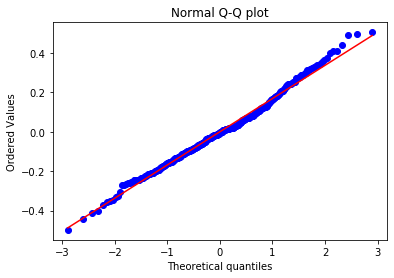

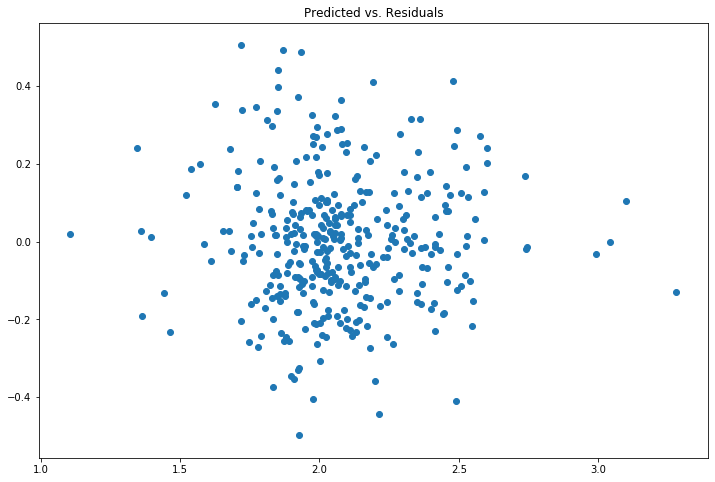

In [78]:
cross_val(
    X_train_interaction,
    y_train,
    model=LinearRegression,
    drop_cols=lasso_columns_remove + drop_after_interaction,
    sm_summary=True,
    resid_plots=True
)

In [79]:
# Removing non-significant features made every metric better

In [80]:
# Barely normal according to metrics
# Trade-offs: Transformations made...
    # Errors less normal
    # Improved fit and accuracy
    # Reduced cross validation variance
    # Became a little less interpretable
    
# Normalcy still looks ok-ish upon visual inspection

# DROP the non-sig columns

## Assess Assumptions of Preferred Model

### Standard Checks

                            OLS Regression Results                            
Dep. Variable:           avg_sat_both   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     133.7
Date:                Thu, 23 Jan 2020   Prob (F-statistic):           4.27e-96
Time:                        16:47:36   Log-Likelihood:                 134.52
No. Observations:                 368   AIC:                            -253.0
Df Residuals:                     360   BIC:                            -221.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

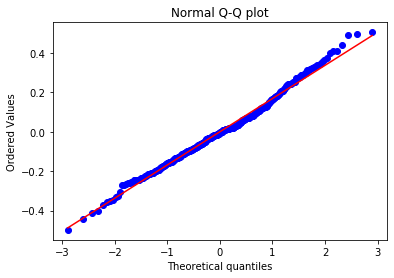

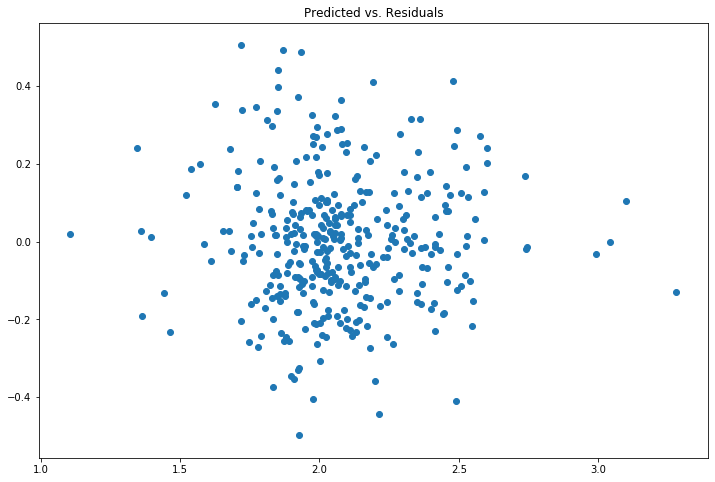

In [81]:
fit_final = run_stats_models(
    X_train_interaction.drop(columns=lasso_columns_remove + drop_after_interaction),
    y_train
)

cross_val(
    X_train_interaction,
    y_train,
    model=LinearRegression,
    drop_cols=lasso_columns_remove + drop_after_interaction,
    sm_summary=True,
    resid_plots=True
)

In [82]:
# a little non-normalcy but seems ok
# Condition Number still really high

### Test for Endogeneity

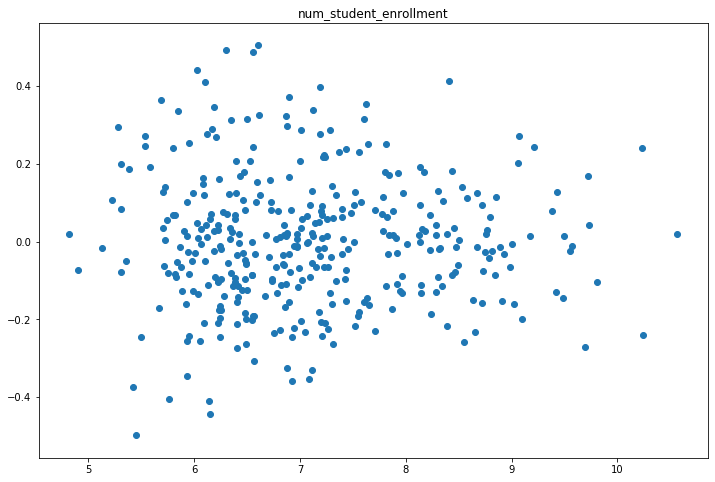

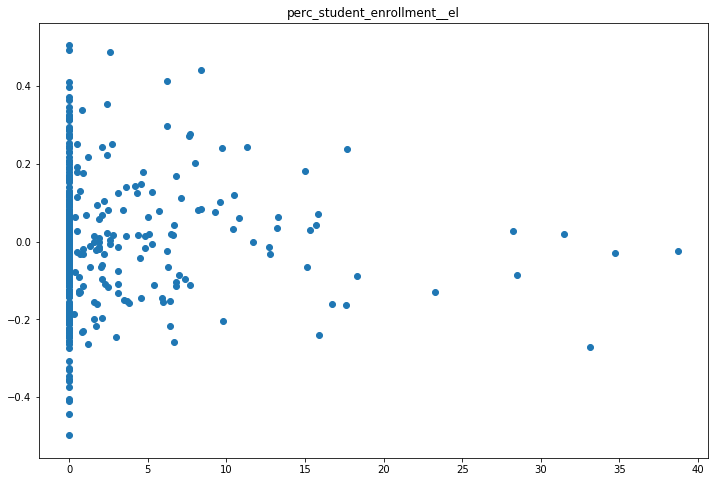

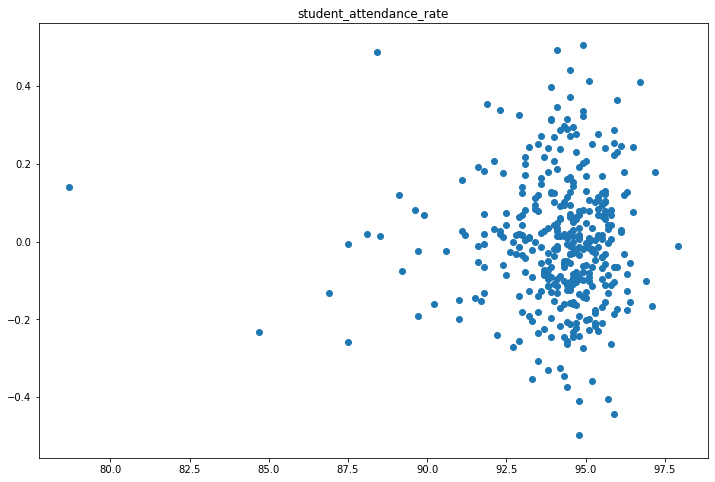

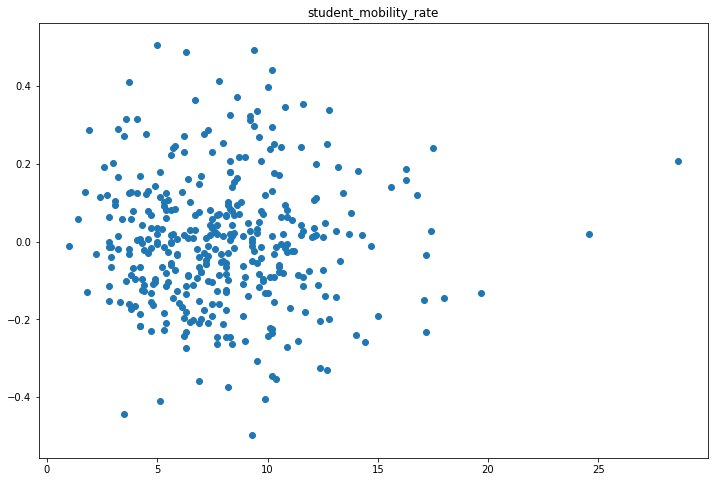

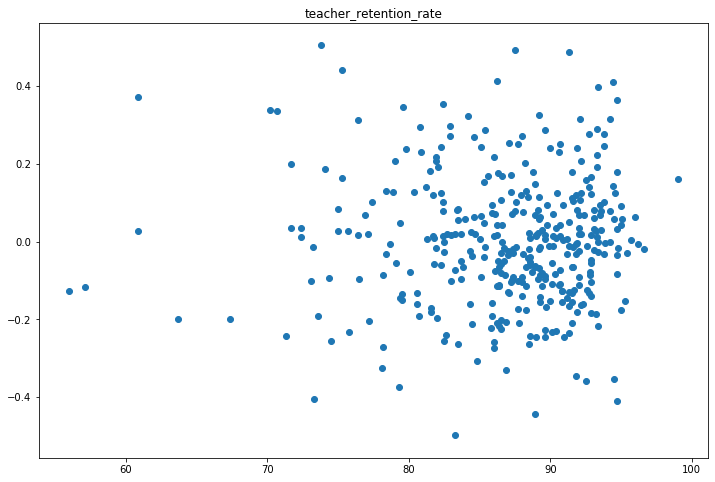

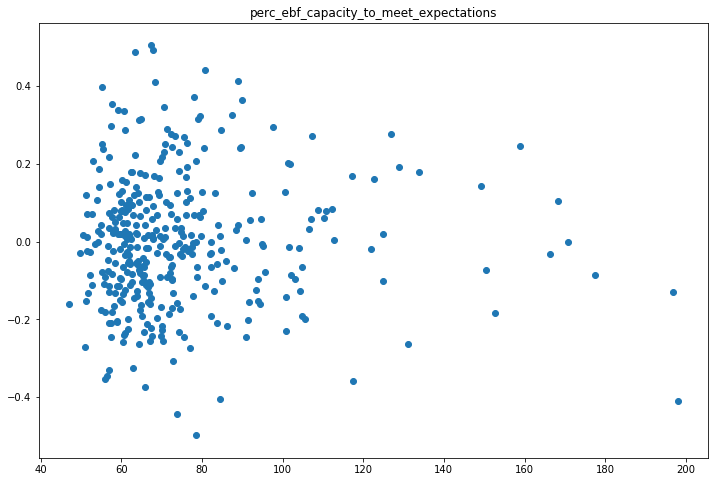

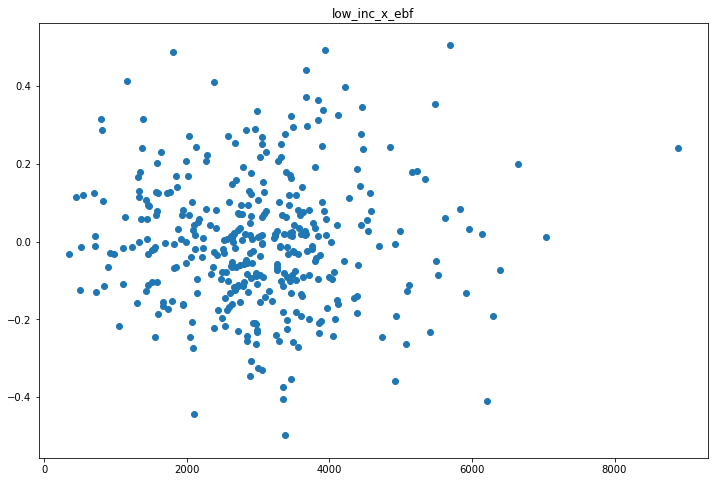

In [83]:
final_features = X_train_interaction.drop(columns=lasso_columns_remove + drop_after_interaction).columns

for col in final_features:
    plt.figure(figsize=(12,8))
    plt.scatter(X_train_interaction[col], fit_final.resid)
    plt.title(col)

In [84]:
final_features = X_train_interaction.drop(columns=lasso_columns_remove + drop_after_interaction)

In [85]:
final_features['resid'] = fit_final.resid

In [86]:
final_features.corr()['resid']

num_student_enrollment                   -2.429716e-15
perc_student_enrollment__el              -6.337131e-17
student_attendance_rate                   8.500851e-15
student_mobility_rate                     1.546781e-15
teacher_retention_rate                    3.905149e-17
perc_ebf_capacity_to_meet_expectations    1.538120e-15
low_inc_x_ebf                             2.274490e-14
resid                                     1.000000e+00
Name: resid, dtype: float64

In [87]:
# looks like all the corrlations between features and residuals are extremely low

## Invstigate Standardization of Final Model

In [88]:
# top model
cross_val(
    X_train_interaction,
    y_train,
    model=LinearRegression,
    drop_cols=lasso_columns_remove + drop_after_interaction,
    sm_summary=True
)

R2 (in sample): 0.72423 +- 0.00510
R2: 0.70063 +- 0.02372
Mean Sq Error: 0.03019 +- 0.00639
Mean abs error: 0.13443 +- 0.01745
AIC (in sample): -201.89487 +- 15.74084
                            OLS Regression Results                            
Dep. Variable:           avg_sat_both   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     133.7
Date:                Thu, 23 Jan 2020   Prob (F-statistic):           4.27e-96
Time:                        16:47:39   Log-Likelihood:                 134.52
No. Observations:                 368   AIC:                            -253.0
Df Residuals:                     360   BIC:                            -221.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                           

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

R2 (in sample): 0.72423 +- 0.00510
R2: 0.70063 +- 0.02372
Mean Sq Error: 0.03019 +- 0.00639
Mean abs error: 0.13443 +- 0.01745
AIC (in sample): -201.89487 +- 15.74084
                            OLS Regression Results                            
Dep. Variable:           avg_sat_both   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     133.7
Date:                Thu, 23 Jan 2020   Prob (F-statistic):           4.27e-96
Time:                        16:47:39   Log-Likelihood:                 134.52
No. Observations:                 368   AIC:                            -253.0
Df Residuals:                     360   BIC:                            -221.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                           

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

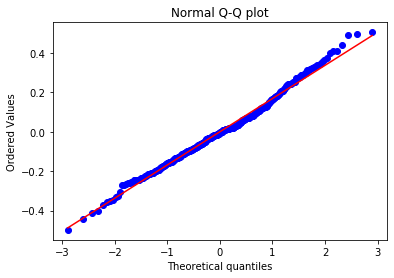

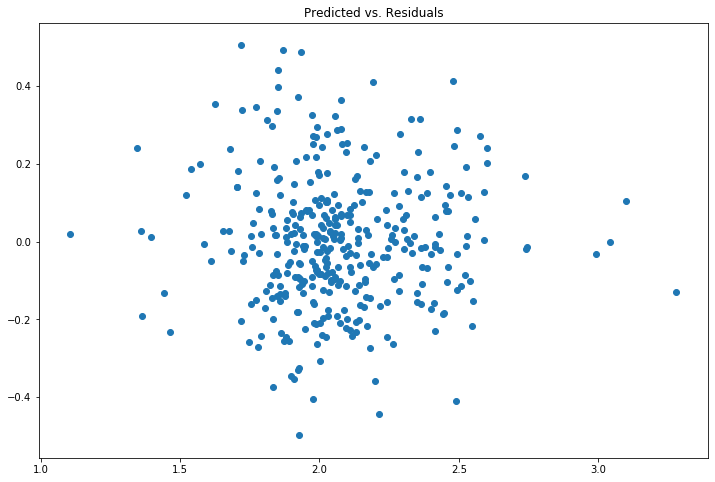

In [89]:
cross_val(
    X_train_interaction,
    y_train,
    model=LinearRegression,
    standardize=True,
    drop_cols=lasso_columns_remove + drop_after_interaction,
    sm_summary=True,
    resid_plots=True
)

In [90]:
# answer matches stats model pretty closesly
# CONDITION NUMBER tanked (that's a good thing) -> perhaps this is the best model?

In [91]:
# Relative importance of differnt features
    # Tier 1
        # % EBF
        # % EBF x low-income
    # Tier 2
        # student enrollment (logged)
    # Tier 3
        # student attendence rate
    # Tier 4
        # student mobility
        # % english learning
    # Tier 5
        # teacher retention

### Check Regularization Techniques

In [92]:
# top model
cross_val(
    X_train_interaction,
    y_train,
    model=LinearRegression,
    standardize=True,
    drop_cols=lasso_columns_remove + drop_after_interaction,
)

R2 (in sample): 0.72423 +- 0.00510
R2: 0.70063 +- 0.02372
Mean Sq Error: 0.03019 +- 0.00639
Mean abs error: 0.13443 +- 0.01745
AIC (in sample): -201.89487 +- 15.74084


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

#### Ridge

In [93]:
for a in [x for x in range(5, 25)]:
    print(f'**** {a} ****')
    cross_val(
        X_train_interaction,
        y_train,
        model=Ridge,
        standardize=True,
        alpha=a,
        drop_cols=lasso_columns_remove + drop_after_interaction,
    )

**** 5 ****
R2 (in sample): 0.72405 +- 0.00512
R2: 0.70100 +- 0.02381
Mean Sq Error: 0.03016 +- 0.00642
Mean abs error: 0.13440 +- 0.01756
AIC (in sample): -201.89487 +- 15.74084
**** 6 ****
R2 (in sample): 0.72397 +- 0.00513
R2: 0.70103 +- 0.02383
Mean Sq Error: 0.03016 +- 0.00643
Mean abs error: 0.13440 +- 0.01759
AIC (in sample): -201.89487 +- 15.74084
**** 7 ****
R2 (in sample): 0.72388 +- 0.00514
R2: 0.70104 +- 0.02385
Mean Sq Error: 0.03016 +- 0.00644
Mean abs error: 0.13440 +- 0.01761
AIC (in sample): -201.89487 +- 15.74084
**** 8 ****
R2 (in sample): 0.72378 +- 0.00515
R2: 0.70105 +- 0.02387
Mean Sq Error: 0.03017 +- 0.00645
Mean abs error: 0.13442 +- 0.01765
AIC (in sample): -201.89487 +- 15.74084
**** 9 ****
R2 (in sample): 0.72367 +- 0.00516
R2: 0.70104 +- 0.02389
Mean Sq Error: 0.03017 +- 0.00646
Mean abs error: 0.13443 +- 0.01768
AIC (in sample): -201.89487 +- 15.74084
**** 10 ****
R2 (in sample): 0.72355 +- 0.00517
R2: 0.70102 +- 0.02391
Mean Sq Error: 0.03017 +- 0.00647


In [94]:
new_ridge_alpha = 8

In [95]:
# Ridge
cross_val(
    X_train_interaction,
    y_train,
    model=Ridge,
    standardize=True,
    alpha=new_ridge_alpha,
    drop_cols=lasso_columns_remove + drop_after_interaction,
)

R2 (in sample): 0.72378 +- 0.00515
R2: 0.70105 +- 0.02387
Mean Sq Error: 0.03017 +- 0.00645
Mean abs error: 0.13442 +- 0.01765
AIC (in sample): -201.89487 +- 15.74084


Ridge(alpha=8, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [96]:
# Ever so slightly better

#### Lasso

In [97]:
for a in [x/3000 for x in range(1, 20)]:
    print(f'**** {a} ****')
    cross_val(
        X_train_interaction,
        y_train,
        model=Lasso,
        standardize=True,
        alpha=a,
        drop_cols=lasso_columns_remove + drop_after_interaction,
    )

**** 0.0003333333333333333 ****
R2 (in sample): 0.72422 +- 0.00510
R2: 0.70069 +- 0.02361
Mean Sq Error: 0.03018 +- 0.00639
Mean abs error: 0.13443 +- 0.01746
AIC (in sample): -201.89487 +- 15.74084
**** 0.0006666666666666666 ****
R2 (in sample): 0.72420 +- 0.00510
R2: 0.70073 +- 0.02351
Mean Sq Error: 0.03018 +- 0.00638
Mean abs error: 0.13442 +- 0.01747
AIC (in sample): -201.89487 +- 15.74084
**** 0.001 ****
R2 (in sample): 0.72417 +- 0.00510
R2: 0.70075 +- 0.02341
Mean Sq Error: 0.03018 +- 0.00638
Mean abs error: 0.13442 +- 0.01749
AIC (in sample): -201.89487 +- 15.74084
**** 0.0013333333333333333 ****
R2 (in sample): 0.72412 +- 0.00510
R2: 0.70076 +- 0.02331
Mean Sq Error: 0.03018 +- 0.00638
Mean abs error: 0.13442 +- 0.01750
AIC (in sample): -201.89487 +- 15.74084
**** 0.0016666666666666668 ****
R2 (in sample): 0.72406 +- 0.00510
R2: 0.70075 +- 0.02321
Mean Sq Error: 0.03018 +- 0.00639
Mean abs error: 0.13442 +- 0.01751
AIC (in sample): -201.89487 +- 15.74084
**** 0.002 ****
R2 (i

In [98]:
new_lasso_alpha = 0.001

In [99]:
# Lasso
cross_val(
    X_train_interaction,
    y_train,
    model=Lasso,
    standardize=True,
    alpha=new_lasso_alpha,
    drop_cols=lasso_columns_remove + drop_after_interaction,
)

R2 (in sample): 0.72417 +- 0.00510
R2: 0.70075 +- 0.02341
Mean Sq Error: 0.03018 +- 0.00638
Mean abs error: 0.13442 +- 0.01749
AIC (in sample): -201.89487 +- 15.74084


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

#### Elastic Net

In [100]:
for a in [x/3000 for x in range(1, 20)]:
    print(f'**** {a} ****')
    cross_val(
        X_train_interaction,
        y_train,
        model=ElasticNet,
        standardize=True,
        alpha=a,
        drop_cols=lasso_columns_remove + drop_after_interaction,
    )

**** 0.0003333333333333333 ****
R2 (in sample): 0.72423 +- 0.00510
R2: 0.70067 +- 0.02366
Mean Sq Error: 0.03019 +- 0.00639
Mean abs error: 0.13443 +- 0.01746
AIC (in sample): -201.89487 +- 15.74084
**** 0.0006666666666666666 ****
R2 (in sample): 0.72422 +- 0.00510
R2: 0.70070 +- 0.02361
Mean Sq Error: 0.03018 +- 0.00639
Mean abs error: 0.13443 +- 0.01746
AIC (in sample): -201.89487 +- 15.74084
**** 0.001 ****
R2 (in sample): 0.72421 +- 0.00510
R2: 0.70072 +- 0.02356
Mean Sq Error: 0.03018 +- 0.00639
Mean abs error: 0.13442 +- 0.01747
AIC (in sample): -201.89487 +- 15.74084
**** 0.0013333333333333333 ****
R2 (in sample): 0.72420 +- 0.00510
R2: 0.70074 +- 0.02351
Mean Sq Error: 0.03018 +- 0.00639
Mean abs error: 0.13442 +- 0.01748
AIC (in sample): -201.89487 +- 15.74084
**** 0.0016666666666666668 ****
R2 (in sample): 0.72418 +- 0.00510
R2: 0.70076 +- 0.02346
Mean Sq Error: 0.03018 +- 0.00639
Mean abs error: 0.13442 +- 0.01749
AIC (in sample): -201.89487 +- 15.74084
**** 0.002 ****
R2 (i

In [101]:
elastic_net_alpha = 0.003

In [102]:
cross_val(
    X_train_interaction,
    y_train,
    model=ElasticNet,
    standardize=True,
    alpha=elastic_net_alpha,
    drop_cols=lasso_columns_remove + drop_after_interaction,
)

R2 (in sample): 0.72407 +- 0.00510
R2: 0.70079 +- 0.02326
Mean Sq Error: 0.03018 +- 0.00639
Mean abs error: 0.13442 +- 0.01752
AIC (in sample): -201.89487 +- 15.74084


ElasticNet(alpha=0.003, copy_X=True, fit_intercept=True, l1_ratio=0.5,
           max_iter=1000, normalize=False, positive=False, precompute=False,
           random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [103]:
# Ridge is best (altho they're all basically the same)
# If going to standardize anyway, might as well

## Consider if different null handling would change results

### Perc English Learner -> filled lots of n/a values. What if we removed it?

In [104]:
# top model
cross_val(
    X_train_interaction,
    y_train,
    model=Ridge,
    standardize=True,
    alpha=new_ridge_alpha,
    drop_cols=lasso_columns_remove + drop_after_interaction,
)

R2 (in sample): 0.72378 +- 0.00515
R2: 0.70105 +- 0.02387
Mean Sq Error: 0.03017 +- 0.00645
Mean abs error: 0.13442 +- 0.01765
AIC (in sample): -201.89487 +- 15.74084


Ridge(alpha=8, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [105]:
cross_val(
    X_train_interaction,
    y_train,
    model=Ridge,
    standardize=True,
    alpha=ridge_alpha,
    drop_cols=lasso_columns_remove + drop_after_interaction + ['perc_student_enrollment__el'],
)

R2 (in sample): 0.71226 +- 0.00554
R2: 0.69142 +- 0.02437
Mean Sq Error: 0.03115 +- 0.00671
Mean abs error: 0.13742 +- 0.01799
AIC (in sample): -194.50412 +- 15.39634


Ridge(alpha=23, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

In [106]:
# Definitely got worse
    # How valid is the assumption that they are zero?

In [107]:
# manually collected data from website on ~10% of the districts with NA for perc_student_enrollment__el
# e.g. https://www.illinoisreportcard.com/District.aspx?source=studentcharacteristics&source2=lep&Districtid=24032024C04

ten_perc_sample = [
0.1,
2.4,
0.6,
0.1,
0,
0.8,
0.1,
0.1,
0.1,
0.4,
0.2,
0,
0,
0,
0.2,
0,
0,
0.4,
0,
0.2,
0,
0,
0,
0,
0,
0,
0.3,
0,
0.2,
0
]

In [108]:
np.mean(ten_perc_sample)

0.20666666666666667

In [109]:
np.std(ten_perc_sample)

0.45087569117095777

In [110]:
# Seems like 0 is a defensible null handling strategy given sample

# Final Model Comparisons

In [111]:
# baseline
cross_val(X_train, y_train, model=LinearRegression)

R2 (in sample): 0.70806 +- 0.01117
R2: 0.65944 +- 0.04584
Mean Sq Error: 0.03417 +- 0.00715
Mean abs error: 0.14250 +- 0.01643
AIC (in sample): -167.28770 +- 16.29629


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [112]:
# super sparse
cross_val(X_train, y_train, model=LinearRegression, drop_cols=top_six_complement)

R2 (in sample): 0.67800 +- 0.01227
R2: 0.65099 +- 0.04866
Mean Sq Error: 0.03494 +- 0.00724
Mean abs error: 0.14587 +- 0.01885
AIC (in sample): -158.44338 +- 14.94978


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

R2 (in sample): 0.70669 +- 0.00709
R2: 0.68369 +- 0.03704
Mean Sq Error: 0.03205 +- 0.00779
Mean abs error: 0.13729 +- 0.02142
AIC (in sample): -185.77483 +- 17.75355
                            OLS Regression Results                            
Dep. Variable:           avg_sat_both   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     143.5
Date:                Thu, 23 Jan 2020   Prob (F-statistic):           2.15e-92
Time:                        16:47:42   Log-Likelihood:                 123.15
No. Observations:                 368   AIC:                            -232.3
Df Residuals:                     361   BIC:                            -205.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                           

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

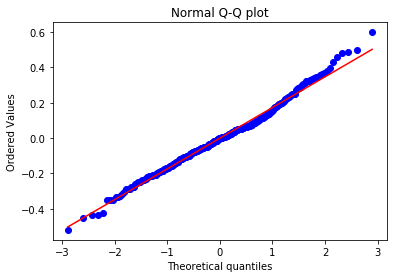

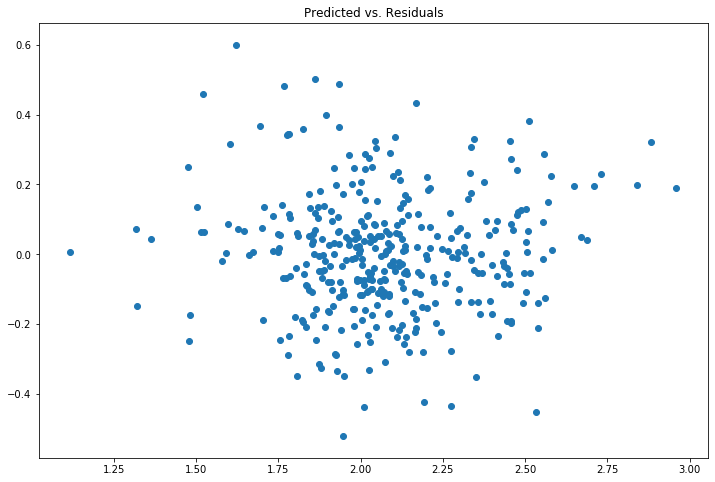

In [113]:
# without ebf_x_low_inc

cross_val(
    X_train_log,
    y_train,
    model=LinearRegression,
#     standardize=True,
    drop_cols=lasso_columns_remove + ['bachelor_degree', 'avg_class_size__high_school', 'pupil_admin_ratio', 'student_mobility_rate'],
    sm_summary=True,
    resid_plots=True
)

In [114]:
# with interaction terms -> seven (logged enrollment, added interaction term, swapped teach_ret in for avg_class_size)
cross_val(
    X_train_interaction,
    y_train,
    model=LinearRegression,
    drop_cols=lasso_columns_remove + drop_after_interaction,
#     sm_summary=True
)

R2 (in sample): 0.72423 +- 0.00510
R2: 0.70063 +- 0.02372
Mean Sq Error: 0.03019 +- 0.00639
Mean abs error: 0.13443 +- 0.01745
AIC (in sample): -201.89487 +- 15.74084


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [115]:
# with standardized features (exactly the same but WAY lower condition number - 2.2*10^5 to 2.94)
cross_val(
    X_train_interaction,
    y_train,
    model=LinearRegression,
    standardize=True,
    drop_cols=lasso_columns_remove + drop_after_interaction
)

R2 (in sample): 0.72423 +- 0.00510
R2: 0.70063 +- 0.02372
Mean Sq Error: 0.03019 +- 0.00639
Mean abs error: 0.13443 +- 0.01745
AIC (in sample): -201.89487 +- 15.74084


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [186]:
new_ridge_alpha

8

R2 (in sample): 0.72378 +- 0.00515
R2: 0.70105 +- 0.02387
Mean Sq Error: 0.03017 +- 0.00645
Mean abs error: 0.13442 +- 0.01765
AIC (in sample): -201.89487 +- 15.74084
                            OLS Regression Results                            
Dep. Variable:           avg_sat_both   R-squared:                       0.722
Model:                            OLS   Adj. R-squared:                  0.717
Method:                 Least Squares   F-statistic:                     133.7
Date:                Fri, 24 Jan 2020   Prob (F-statistic):           4.27e-96
Time:                        09:45:58   Log-Likelihood:                 134.52
No. Observations:                 368   AIC:                            -253.0
Df Residuals:                     360   BIC:                            -221.8
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                                           

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


Ridge(alpha=8, copy_X=True, fit_intercept=True, max_iter=None, normalize=False,
      random_state=None, solver='auto', tol=0.001)

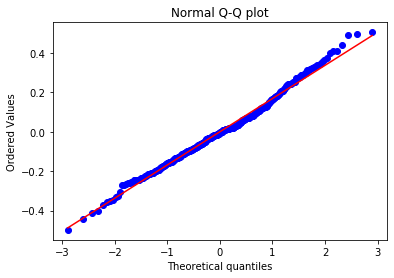

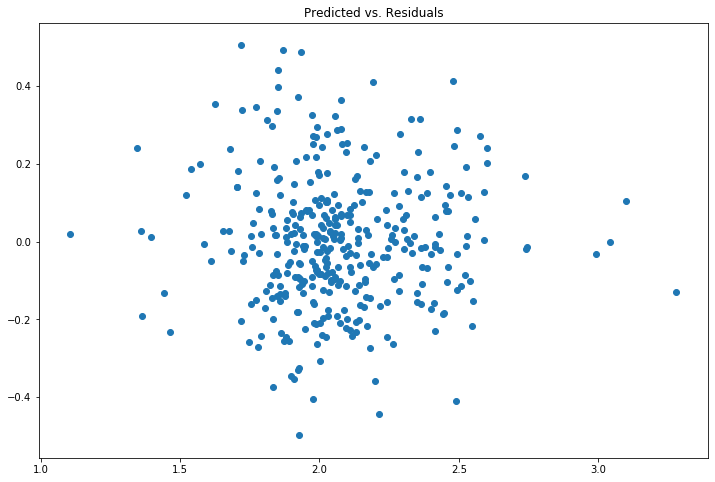

In [192]:
# Ridge
cross_val(
    X_train_interaction,
    y_train,
    model=Ridge,
    standardize=True,
    alpha=new_ridge_alpha,
    drop_cols=lasso_columns_remove + drop_after_interaction,
    sm_summary=True,
    resid_plots=True
)

# Do Teacher Variables Make a Difference

In [117]:
# does adding in outliers affect model (chicago, homeless one)
# does imputing teacher attendence and not dropping those rows affect model
# can I add in teacher variables

In [118]:
with_teacher_features = X_train_interaction.copy()
with_teacher_features['bach_x_exp'] = with_teacher_features['bachelor_degree'] * with_teacher_features['avg_teaching_exp']

In [119]:
cols_to_drop = list(set(lasso_columns_remove + drop_after_interaction) - set(['bachelor_degree', 'avg_teaching_exp']))

In [120]:
cross_val(
    with_teacher_features,
    y_train,
    model=LinearRegression,
    standardize=True,
#     alpha=new_ridge_alpha,
    drop_cols=lasso_columns_remove + drop_after_interaction,
    sm_summary=True
)

R2 (in sample): 0.72710 +- 0.00539
R2: 0.70289 +- 0.02634
Mean Sq Error: 0.02999 +- 0.00656
Mean abs error: 0.13373 +- 0.01743
AIC (in sample): -202.98061 +- 16.34756
                            OLS Regression Results                            
Dep. Variable:           avg_sat_both   R-squared:                       0.725
Model:                            OLS   Adj. R-squared:                  0.719
Method:                 Least Squares   F-statistic:                     118.3
Date:                Thu, 23 Jan 2020   Prob (F-statistic):           8.60e-96
Time:                        16:47:43   Log-Likelihood:                 136.36
No. Observations:                 368   AIC:                            -254.7
Df Residuals:                     359   BIC:                            -219.5
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                                           

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [121]:
# Interaction term is almost significant
# Makes model a little better error wise (~1% better, slightly lower variance)
# Model got a little less stable R2

# Omit it since it's not statistically significant

# Final Model

## Baseline Comparison

In [183]:
# baseline
cross_val(X_train, y_train, model=LinearRegression)

R2 (in sample): 0.70806 +- 0.01117
R2: 0.65944 +- 0.04584
Mean Sq Error: 0.03417 +- 0.00715
Mean abs error: 0.14250 +- 0.01643
AIC (in sample): -167.28770 +- 16.29629


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [184]:
# final
cross_val(
    X_train_log,
    y_train,
    model=LinearRegression,
#     standardize=True,
    drop_cols=lasso_columns_remove + ['bachelor_degree', 'avg_class_size__high_school', 'pupil_admin_ratio', 'student_mobility_rate'],
    sm_summary=True
)

R2 (in sample): 0.70669 +- 0.00709
R2: 0.68369 +- 0.03704
Mean Sq Error: 0.03205 +- 0.00779
Mean abs error: 0.13729 +- 0.02142
AIC (in sample): -185.77483 +- 17.75355
                            OLS Regression Results                            
Dep. Variable:           avg_sat_both   R-squared:                       0.705
Model:                            OLS   Adj. R-squared:                  0.700
Method:                 Least Squares   F-statistic:                     143.5
Date:                Fri, 24 Jan 2020   Prob (F-statistic):           2.15e-92
Time:                        09:27:11   Log-Likelihood:                 123.15
No. Observations:                 368   AIC:                            -232.3
Df Residuals:                     361   BIC:                            -205.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                           

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

## Validate Against Test Set

In [124]:
from sklearn import metrics

X_test_log = X_test.copy()
X_test_log['num_student_enrollment'] = np.log(X_test_log['num_student_enrollment'])

final_lm = LinearRegression()
final_fit = final_lm.fit(
    X_train_log.drop(columns=lasso_columns_remove + ['bachelor_degree', 'avg_class_size__high_school', 'pupil_admin_ratio', 'student_mobility_rate']),
    y_train
)

in_sample_preds = final_fit.predict(X_train_log.drop(columns=lasso_columns_remove + ['bachelor_degree', 'avg_class_size__high_school', 'pupil_admin_ratio', 'student_mobility_rate']))
test_preds = final_fit.predict(X_test_log.drop(columns=lasso_columns_remove + ['bachelor_degree', 'avg_class_size__high_school', 'pupil_admin_ratio', 'student_mobility_rate']))

print(metrics.r2_score(y_true=y_test, y_pred=test_preds))
print(metrics.mean_squared_error(y_true=y_test, y_pred=test_preds))
print(metrics.mean_absolute_error(y_true=y_test, y_pred=test_preds))

0.6258682160422547
0.038930381341322186
0.14890651291361065


In [125]:
print_coef(
    X_train_log.drop(columns=lasso_columns_remove + ['bachelor_degree', 'avg_class_size__high_school', 'pupil_admin_ratio', 'student_mobility_rate']).columns,
    final_fit.coef_
)

num_student_enrollment: 0.09464361982512108
student_attendance_rate: 0.03474648019774004
perc_student_enrollment__low_income: -0.008677930770838359
perc_student_enrollment__el: -0.0055877778215902615
teacher_retention_rate: 0.004709611651122528
perc_ebf_capacity_to_meet_expectations: 0.0030417360649252303


                            OLS Regression Results                            
Dep. Variable:           avg_sat_both   R-squared:                       0.689
Model:                            OLS   Adj. R-squared:                  0.685
Method:                 Least Squares   F-statistic:                     167.8
Date:                Thu, 23 Jan 2020   Prob (F-statistic):          7.71e-112
Time:                        16:47:43   Log-Likelihood:                 141.32
No. Observations:                 461   AIC:                            -268.6
Df Residuals:                     454   BIC:                            -239.7
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                             coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------

/Users/willyraedy/anaconda3/envs/metis/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2495: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


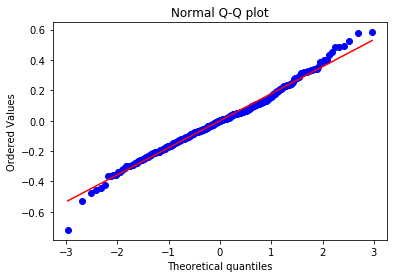

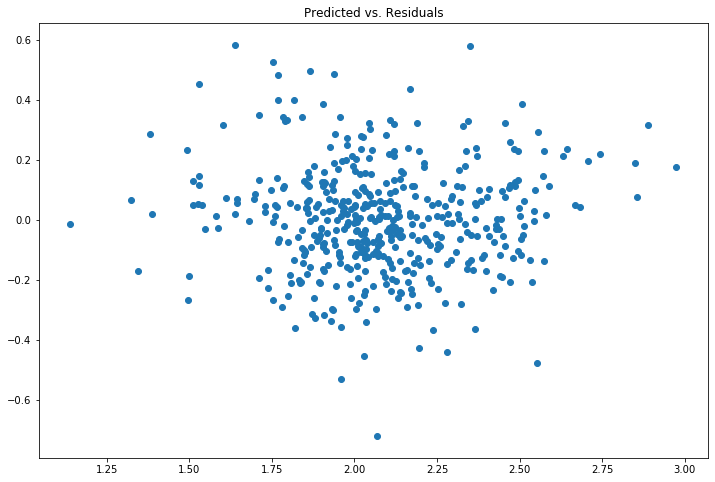

In [126]:
X_all = X.copy()
X_all['num_student_enrollment'] = np.log(X_all['num_student_enrollment'])

final_sm = run_stats_models(
    X_all.drop(columns=lasso_columns_remove + ['bachelor_degree', 'avg_class_size__high_school', 'pupil_admin_ratio', 'student_mobility_rate']),
    y
)

generate_resid_plots(final_sm)

In [174]:
X_all.drop(columns=lasso_columns_remove + ['bachelor_degree', 'avg_class_size__high_school', 'pupil_admin_ratio', 'student_mobility_rate']).describe()

num_student_enrollment  perc_student_enrollment__low_income  \
count              461.000000                           461.000000   
mean                 7.087926                            42.491757   
std                  1.067074                            18.257985   
min                  4.820282                             2.100000   
25%                  6.300786                            29.600000   
50%                  6.917706                            42.600000   
75%                  7.720018                            53.800000   
max                 10.565247                            99.600000   

       perc_student_enrollment__el  student_attendance_rate  \
count                   461.000000               461.000000   
mean                      2.500651                94.095445   
std                       5.625831                 1.850993   
min                       0.000000                78.700000   
25%                       0.000000                93.600000   
50%                       0.000000                94.500000   
75%                       2.300000                95.100000   
max                      39.000000                98.200000   

       teacher_retention_rate  perc_ebf_capacity_to_meet_expectations  
count              461.000000                              461.000000  
mean                86.826681                               74.126898  
std                  6.470398                               21.966172  
min                 56.000000                               47.000000  
25%                 83.700000                               60.700000  
50%                 88.200000                               67.700000  
75%                 91.500000                               78.800000  
max                 99.000000                              198.000000

# Get Relative Importances

In [177]:
X_test_log = X_test.copy()
X_test_log['num_student_enrollment'] = np.log(X_test_log['num_student_enrollment'])

# scaler = StandardScaler()
# X_all_log_sc = scaler.fit_transform(X_all.drop(columns=lasso_columns_remove + ['bachelor_degree', 'avg_class_size__high_school', 'pupil_admin_ratio', 'student_mobility_rate']))

final_lm_sc = LinearRegression()
final_fit_sc = final_lm_sc.fit(
    X_all.drop(columns=lasso_columns_remove + ['bachelor_degree', 'avg_class_size__high_school', 'pupil_admin_ratio', 'student_mobility_rate']),
    y
)

print_coef(
    X_train_log.drop(columns=lasso_columns_remove + ['bachelor_degree', 'avg_class_size__high_school', 'pupil_admin_ratio', 'student_mobility_rate']).columns,
    final_fit_sc.coef_
)

num_student_enrollment: 0.09178446350983345
student_attendance_rate: 0.03383298357905736
perc_student_enrollment__low_income: -0.008583702472800884
perc_student_enrollment__el: -0.006115374683585231
teacher_retention_rate: 0.004011275799097501
perc_ebf_capacity_to_meet_expectations: 0.0032285885070556736


In [180]:
final_features = X_all.drop(columns=lasso_columns_remove + ['bachelor_degree', 'avg_class_size__high_school', 'pupil_admin_ratio', 'student_mobility_rate'])
final_features['avg_sat_level'] = y

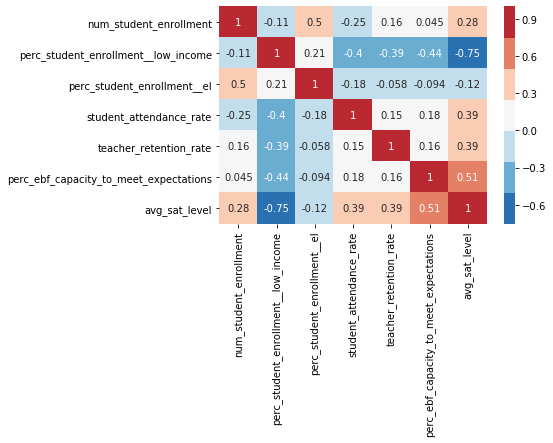

In [181]:
import seaborn as sns

sns.heatmap(final_features.corr(), annot=True, cmap=sns.color_palette("RdBu_r", 7))

# Get Examplels for Pres

In [168]:
pres_data = for_model.copy()

In [171]:
pres_data.num_student_enrollment = np.log(pres_data.num_student_enrollment)

In [172]:
pres_data[(pres_data.perc_ebf_capacity_to_meet_expectations > 100) & (pres_data.perc_ebf_capacity_to_meet_expectations < 175)]

avg_sat_both  num_student_enrollment  perc_student_enrollment__homeless  \
11         1.7740                5.303305                                0.0   
47         2.0235                6.413459                                0.0   
49         2.5765                8.173857                                4.8   
51         2.4470                8.759355                                0.9   
52         2.5390                9.379323                                1.5   
53         2.5740                9.395076                                1.2   
55         2.7165                8.135933                                0.8   
57         2.7200                8.311890                                0.9   
60         1.9630                8.148156                                1.0   
61         2.1240                6.770789                                1.1   
65         2.6140                7.257003                                0.0   
76         2.0665                6.475433                                0.0   
80         2.3195                6.726233                                0.0   
83         2.2895                6.236370                                0.0   
84         2.7300                5.533389                                0.0   
109        1.6835                5.988961                                0.0   
141        2.2000                6.545350                                0.0   
148        1.9260                7.533694                                1.0   
166        2.8800                8.379769                                1.3   
170        2.5945                8.506739                                0.7   
171        2.0830                7.308543                                0.9   
172        2.4920                7.869019                                0.8   
174        2.5665                7.192934                                1.7   
175        2.5975                7.305860                                1.4   
176        2.9035                9.720406                                0.7   
178        2.8030                9.059401                                0.3   
210        2.1850                7.709757                                0.7   
214        2.2280                5.123964                                0.0   
266        2.7190                9.428833                                0.9   
267        2.7280                8.670944                                0.4   
284        1.9655                5.552960                                3.9   
290        2.7020                8.646993                                0.0   
291        2.9325                8.209852                                0.0   
292        2.9610                7.395108                                0.0   
299        3.2045                8.349957                                0.3   
302        3.0385                8.130648                                0.4   
304        2.8460                9.071768                                0.3   
306        1.8985                6.486161                                0.0   
323        2.4350                7.392032                                0.7   
324        1.8665                5.308268                                0.0   
340        1.8690                7.543803                                1.9   
363        1.8395                6.921658                                7.1   
376        2.4410                7.342779                                0.0   
377        2.2650                6.475433                                0.0   
442        1.9165                4.897840                                0.0   
459        2.0010                7.313220                                1.0   

     perc_student_enrollment__low_income  perc_student_enrollment__iep  \
11                                  65.2                          19.9   
47                                  30.8                          16.7   
49                    